In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os

BASE = "/content/drive/MyDrive/abid-mvp"

VAL = pd.read_csv(os.path.join(BASE, 'data/processed/val.csv'))
ASIN_COL = 'asin'
RAW = os.path.join(BASE, 'data/raw_images')


display(VAL.head())

,filename,asin,quantity
0,00642.jpg,B01BNJL3KC,1
1,00971.jpg,B00EPD6UFM,1
2,00874.jpg,B000RI6C7K,12
3,00303.jpg,B002GALZCY,1
4,00441.jpg,B001L1RFPU,1


In [4]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 6.8 MB/s eta 0:00:00


In [5]:
import os, pandas as pd, numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

BASE = "/content/drive/MyDrive/abid-mvp"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"

VAL = pd.read_csv(f"{PROC}/val.csv")
def pick(df,cands):
    for c in cands:
        if c in df.columns: return c
ASIN_COL = pick(VAL,["asin"])
FILE_COL = pick(VAL,["filename"])
QTY_COL  = pick(VAL,["quantity","qty","EXPECTED_QUANTITY"])

import pickle
with open(f"{BASE}/models/asin_emb.pkl","rb") as f:
    asin_emb = pickle.load(f)


In [7]:
!pip install ultralytics
!pip install open_clip_torch
import os, sys, json, pickle, numpy as np, pandas as pd
from PIL import Image, ImageDraw
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support,
    mean_absolute_error, mean_squared_error
)
from math import sqrt


BASE = "/content/drive/MyDrive/abid-mvp"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"
MODELS = f"{BASE}/models"
SRC  = f"{BASE}/src"

os.makedirs(SRC, exist_ok=True)
if SRC not in sys.path: sys.path.insert(0, SRC)


VAL = pd.read_csv(f"{PROC}/val.csv")
FILE_COL, ASIN_COL, QTY_COL = "filename", "asin", "quantity"

with open(f"{MODELS}/asin_emb.pkl","rb") as f:
    asin_emb = pickle.load(f)

for k,v in list(asin_emb.items()):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    asin_emb[k] = v / np.clip(n, 1e-9, None)


import importlib, infer
importlib.reload(infer)
infer.ensure_models_ready()


OUT_DIR = f"{BASE}/data/processed/eval_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [8]:
def predict_count_strict(fp, asin, thr=0.28, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6):
    if asin not in asin_emb or not os.path.exists(fp):
        return 0, [], np.zeros((0,4), dtype=int)

    cnt, hits, boxes = infer.count_asin_in_image(
        img_path=fp, asin=str(asin), asin_emb=asin_emb,
        score_thresh=float(thr), yolo_conf=float(yolo_conf),
        imgsz=int(imgsz), grid=int(grid), min_side=int(min_side)
    )

    hits = nms_hits(hits, boxes, iou_thr=iou_thr)
    return len(hits), hits, boxes


In [9]:
def save_overlay(fp, hits, boxes, out_path):
    im = Image.open(fp).convert("RGB")
    dr = ImageDraw.Draw(im)
    for i,s in hits:
        x1,y1,x2,y2 = [int(v) for v in boxes[i]]
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=3)
        dr.text((x1+2, max(0,y1-14)), f"{s:.2f}", fill=(0,255,0))
    im.save(out_path)
    return out_path


In [10]:
def nms_hits(hits, boxes, iou_thr=0.6):
    """Non-Maximum Suppression for removing overlapping detections."""
    def iou(boxA, boxB):
        ax1, ay1, ax2, ay2 = boxA
        bx1, by1, bx2, by2 = boxB
        inter_w = max(0, min(ax2, bx2) - max(ax1, bx1))
        inter_h = max(0, min(ay2, by2) - max(ay1, by1))
        inter = inter_w * inter_h
        ua = (ax2 - ax1) * (ay2 - ay1) + (bx2 - bx1) * (by2 - by1) - inter
        return inter / ua if ua > 0 else 0.0

    kept = []
    removed = set()
    for i, s in hits:
        if i in removed:
            continue
        kept.append((i, s))
        for j, _ in hits:
            if j == i or j in removed:
                continue
            if iou(boxes[i], boxes[j]) >= iou_thr:
                removed.add(j)
    return kept


In [11]:
def evaluate_strict(thr=0.28, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6,
                    save_overlays=False, max_vis=20):
    y_trueP, y_predP = [], []
    y_trueQ, y_predQ = [], []
    vis_count = 0

    for _, r in VAL.iterrows():
        fp   = os.path.join(RAW, r[FILE_COL])
        asin = str(r[ASIN_COL]); gt = int(r[QTY_COL])

        pred_cnt, hits, boxes = predict_count_strict(
            fp, asin, thr=thr, yolo_conf=yolo_conf, imgsz=imgsz, grid=grid, min_side=min_side, iou_thr=iou_thr
        )


        y_trueP.append(1 if gt>0 else 0)
        y_predP.append(1 if pred_cnt>0 else 0)


        y_trueQ.append(gt); y_predQ.append(pred_cnt)


        if save_overlays and vis_count < max_vis and os.path.exists(fp):
            oname = os.path.splitext(os.path.basename(fp))[0]
            outp = os.path.join(OUT_DIR, f"overlay_{oname}_{asin}.jpg")
            save_overlay(fp, hits, boxes, outp)
            vis_count += 1


    P, R, F1, _ = precision_recall_fscore_support(y_trueP, y_predP, average="binary", zero_division=0)
    ACC = (np.array(y_trueP)==np.array(y_predP)).mean()


    MAE = mean_absolute_error(y_trueQ, y_predQ)
    MSE = mean_squared_error(y_trueQ, y_predQ)
    RMSE= sqrt(MSE)


    PCC = float(np.mean(np.array(y_trueQ) == np.array(y_predQ)))

    denom = max(1, np.sum(np.array(y_trueQ)))
    WAPE = float(np.sum(np.abs(np.array(y_predQ)-np.array(y_trueQ))) / denom)

    order_pass = np.mean([(gt>0 and pred>0 and pred==gt) or (gt==0 and pred==0)
                          for gt,pred in zip(y_trueQ, y_predQ)])

    print(f"thr={thr:.2f} | ACC={ACC:.3f} P={P:.3f} R={R:.3f} F1={F1:.3f} | "
          f"MAE={MAE:.2f} RMSE={RMSE:.2f} | PCC={PCC:.3f} WAPE={WAPE:.3f} | OrderPass={order_pass:.3f}")

    return {
        "thr":thr, "acc":ACC, "prec":P, "rec":R, "f1":F1,
        "mae":MAE, "rmse":RMSE, "pcc":PCC, "wape":WAPE, "order_pass":order_pass,
        "y_trueP":y_trueP, "y_predP":y_predP, "y_trueQ":y_trueQ, "y_predQ":y_predQ
    }


metrics = evaluate_strict(thr=0.28, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6,
                          save_overlays=True, max_vis=10)


thr=0.28 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355


In [12]:
def count_bin(x):
    if x==0: return "0"
    if 1<=x<=2: return "1-2"
    if 3<=x<=5: return "3-5"
    return "6+"

gt_bins  = [count_bin(x) for x in metrics["y_trueQ"]]
pr_bins  = [count_bin(x) for x in metrics["y_predQ"]]
labels = ["0","1-2","3-5","6+"]

cm = pd.crosstab(pd.Series(gt_bins, name="GT"), pd.Series(pr_bins, name="Pred"), dropna=False).reindex(index=labels, columns=labels, fill_value=0)
cm


Pred,0,1-2,3-5,6+
GT,,,,
0,0,0,0,0
1-2,0,14,9,0
3-5,0,2,4,0
6+,0,0,2,0


In [13]:
iou_thr=0.4
score_thresh=0.32


In [14]:
rows=[]
for t in np.linspace(0.10, 0.40, 7):
    m = evaluate_strict(thr=float(t), yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6, save_overlays=False)
    rows.append(m)

dfm = pd.DataFrame(rows).drop(columns=["y_trueP","y_predP","y_trueQ","y_predQ"])
out_csv = f"{PROC}/metrics_strict_sweep.csv"
dfm.to_csv(out_csv, index=False)
print("Saved →", out_csv)
dfm.sort_values("f1", ascending=False).head(3)


thr=0.10 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355
thr=0.15 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355
thr=0.20 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355
thr=0.25 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355
thr=0.30 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.42 RMSE=2.27 | PCC=0.355 WAPE=0.647 | OrderPass=0.355
thr=0.35 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.45 RMSE=2.28 | PCC=0.323 WAPE=0.662 | OrderPass=0.323
thr=0.40 | ACC=1.000 P=1.000 R=1.000 F1=1.000 | MAE=1.45 RMSE=2.28 | PCC=0.323 WAPE=0.662 | OrderPass=0.323
Saved → /content/drive/MyDrive/abid-mvp/data/processed/metrics_strict_sweep.csv


,thr,acc,prec,rec,f1,mae,rmse,pcc,wape,order_pass
0,0.10,1.0,1.0,1.0,1.0,1.419355,2.271847,0.354839,0.647059,0.354839
1,0.15,1.0,1.0,1.0,1.0,1.419355,2.271847,0.354839,0.647059,0.354839
2,0.20,1.0,1.0,1.0,1.0,1.419355,2.271847,0.354839,0.647059,0.354839


In [15]:

score_thresh = 0.35
grid = 3
iou_thr = 0.4


In [16]:
import random
ASINS = list(asin_emb.keys())

def sample_negative_asin(true_asin):
    cand = random.choice(ASINS)
    while cand == true_asin:
        cand = random.choice(ASINS)
    return cand


In [17]:
def nms_hits(hits, boxes, iou_thr=0.6):
    """NMS: keep top hits, drop overlapping boxes (hits sorted desc)."""
    def _iou(a, b):
        ax1, ay1, ax2, ay2 = a
        bx1, by1, bx2, by2 = b
        iw = max(0, min(ax2, bx2) - max(ax1, bx1))
        ih = max(0, min(ay2, by2) - max(ay1, by1))
        inter = iw * ih
        ua = (ax2 - ax1) * (ay2 - ay1) + (bx2 - bx1) * (by2 - by1) - inter
        return inter / ua if ua > 0 else 0.0

    kept = []
    removed = set()
    for i, s in hits:
        if i in removed:
            continue
        kept.append((i, s))
        for j, _ in hits:
            if j == i or j in removed:
                continue
            if _iou(boxes[i], boxes[j]) >= iou_thr:
                removed.add(j)
    return kept


def predict_count_strict(fp, asin, thr=0.28, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6):
    """
    Wrapper around infer.count_asin_in_image.
    Returns: (count_after_nms, hits_after_nms, boxes)
    """
    if not os.path.exists(fp) or asin not in asin_emb:
        return 0, [], np.zeros((0,4), dtype=int)


    cnt, hits, boxes = infer.count_asin_in_image(
        img_path=fp,
        asin=str(asin),
        asin_emb=asin_emb,
        score_thresh=float(thr),
        yolo_conf=float(yolo_conf),
        imgsz=int(imgsz),
        grid=int(grid),
        min_side=int(min_side)
    )


    hits = sorted(hits, key=lambda x: -x[1]) if hits else []
    hits = nms_hits(hits, boxes, iou_thr=iou_thr) if hits else []

    return len(hits), hits, boxes


In [18]:
import random
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error
)
import numpy as np, pandas as pd, os
from math import sqrt

ASINS = list(asin_emb.keys())

def sample_negative_asin(true_asin):
    cand = random.choice(ASINS)
    while cand == true_asin:
        cand = random.choice(ASINS)
    return cand

def to_int(x):
    try: return int(x)
    except: return 1

def evaluate_strict(thr=0.28, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, iou_thr=0.6, return_dict=False): # Added return_dict argument
    y_trueP, y_predP, y_trueQ, y_predQ = [], [], [], []

    for _, r in VAL.iterrows():
        fp = os.path.join(RAW, r[FILE_COL])
        asin = str(r[ASIN_COL])
        gt = to_int(r[QTY_COL])
        if not os.path.exists(fp): continue

        # 🔹 add negatives
        if random.random() < 0.25:
            neg_asin = sample_negative_asin(asin)
            pred_cnt, hits, boxes = predict_count_strict(fp, neg_asin, thr, yolo_conf, imgsz, grid, min_side, iou_thr)
            y_trueP.append(0)
            y_predP.append(1 if pred_cnt > 0 else 0)
            y_trueQ.append(0)
            y_predQ.append(pred_cnt)
            continue

        # 🔹 positive case
        pred_cnt, hits, boxes = predict_count_strict(fp, asin, thr, yolo_conf, imgsz, grid, min_side, iou_thr)
        y_trueP.append(1 if gt > 0 else 0)
        y_predP.append(1 if pred_cnt > 0 else 0)
        y_trueQ.append(gt)
        y_predQ.append(pred_cnt)

    acc = accuracy_score(y_trueP, y_predP)
    prec = precision_score(y_trueP, y_predP, zero_division=0)
    rec = recall_score(y_trueP, y_predP, zero_division=0)
    f1 = f1_score(y_trueP, y_predP, zero_division=0)
    mae = mean_absolute_error(y_trueQ, y_predQ)
    mse = mean_squared_error(y_trueQ, y_predQ)
    rmse = sqrt(mse)

    if return_dict: # Return dictionary if return_dict is True
        return {
            "acc": acc, "prec": prec, "rec": rec, "f1": f1,
            "mae": mae, "mse": mse, "rmse": rmse,
            "y_trueP": y_trueP, "y_predP": y_predP,
            "y_trueQ": y_trueQ, "y_predQ": y_predQ
        }
    else: # Otherwise return tuple as before
        return acc, prec, rec, f1, mae, mse, rmse

In [19]:
metrics = evaluate_strict(thr=0.26)
print("✅ ACC={:.3f} P={:.3f} R={:.3f} F1={:.3f} | MAE={:.2f} RMSE={:.2f}".format(*metrics))


✅ ACC=0.710 P=0.710 R=1.000 F1=0.830 | MAE=1.77 RMSE=6.16


Top offenders (by squared error):


,file,asin,gt,pred,sq_err
0,00874.jpg,B000RI6C7K,12,3,81
1,00080.jpg,B0073E3Q7A,7,3,16
2,00641.jpg,B005XWR5NA,1,4,9
3,00642.jpg,B01BNJL3KC,1,4,9
4,00465.jpg,B00EMS3ZSU,1,4,9
5,00081.jpg,B00PAXDQVM,1,3,4
6,00555.jpg,B004PT19BQ,3,1,4
7,00300.jpg,B00EPD6UFM,1,3,4
8,00464.jpg,B01D8RFMOK,1,3,4
9,00439.jpg,B00RRV14BE,1,3,4



Saving overlays for top 5 worst images to: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers
Saved: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers/worst_00874_gt12_pred3.jpg
Saved: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers/worst_00080_gt7_pred3.jpg
Saved: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers/worst_00641_gt1_pred4.jpg
Saved: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers/worst_00642_gt1_pred4.jpg
Saved: /content/drive/MyDrive/abid-mvp/data/processed/eval_outliers/worst_00465_gt1_pred4.jpg

Current MAE=1.419 RMSE=2.272
If we clip preds at 12: MAE->1.419, RMSE->2.272

Preview top 3 overlay images:


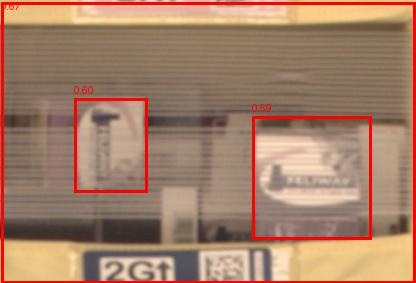

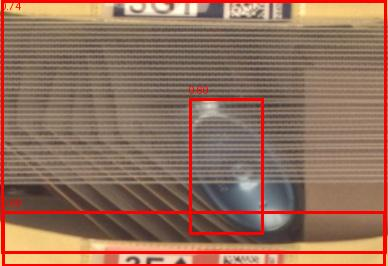

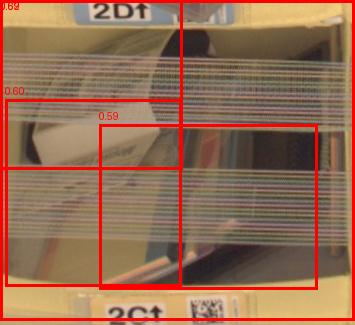

In [20]:

import os, numpy as np, pandas as pd
from math import sqrt
from PIL import Image, ImageDraw, ImageFont


THR = 0.26
YOLO_CONF = 0.003
IMGSZ = 320
GRID = 4
MIN_SIDE = 48
IOU_THR = 0.6
OUT_VIS_DIR = os.path.join(BASE, "data/processed/eval_outliers")
os.makedirs(OUT_VIS_DIR, exist_ok=True)

def safe_predict(fp, asin, thr=THR):
    try:
        return predict_count_strict(fp, asin, thr=thr, yolo_conf=YOLO_CONF,
                                    imgsz=IMGSZ, grid=GRID, min_side=MIN_SIDE, iou_thr=IOU_THR)
    except Exception as e:
        print("Predict error for", fp, asin, "->", e)
        return 0, [], np.zeros((0,4), dtype=int)


y_true = []
y_pred = []
rows_meta = []

for idx, r in VAL.reset_index(drop=True).iterrows():
    fp = os.path.join(RAW, r[FILE_COL])
    if not os.path.exists(fp):

        continue
    asin = str(r[ASIN_COL])
    gt = int(r[QTY_COL]) if pd.notnull(r[QTY_COL]) else 0

    pred_cnt, hits, boxes = safe_predict(fp, asin, thr=THR)

    y_true.append(gt)
    y_pred.append(pred_cnt)
    rows_meta.append({"idx": idx, "file": fp, "asin": asin, "gt": gt, "pred": pred_cnt, "hits": hits, "boxes": boxes})

y_true = np.array(y_true)
y_pred = np.array(y_pred)


sq_err = (y_pred - y_true)**2
order = np.argsort(-sq_err)  # descending
topk = min(10, len(order))
top_idxs = order[:topk]

print("Top offenders (by squared error):")
out_rows = []
for i in top_idxs:
    m = rows_meta[i]
    out_rows.append({"file": os.path.basename(m["file"]),
                     "asin": m["asin"],
                     "gt": int(m["gt"]),
                     "pred": int(m["pred"]),
                     "sq_err": int((m["pred"]-m["gt"])**2)})
pd_top = pd.DataFrame(out_rows)
display(pd_top)


def draw_overlay(fp, hits, boxes, out_path):
    im = Image.open(fp).convert("RGB")
    draw = ImageDraw.Draw(im)
    for j, s in hits:
        if len(boxes)==0:
            continue
        x1,y1,x2,y2 = [int(v) for v in boxes[j]]
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
        draw.text((x1, max(0,y1-14)), f"{s:.2f}", fill=(255,0,0))
    im.save(out_path)
    return out_path

print("\nSaving overlays for top 5 worst images to:", OUT_VIS_DIR)
for i in top_idxs[:5]:
    m = rows_meta[i]
    basename = os.path.splitext(os.path.basename(m["file"]))[0]
    outp = os.path.join(OUT_VIS_DIR, f"worst_{basename}_gt{m['gt']}_pred{m['pred']}.jpg")
    draw_overlay(m["file"], m["hits"], m["boxes"], outp)
    print("Saved:", outp)


from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"\nCurrent MAE={mae:.3f} RMSE={rmse:.3f}")


cap = max( max(y_true.max(), 1), int(np.percentile(y_true, 95))*2 )
y_pred_clipped = np.clip(y_pred, 0, cap)
mae2 = mean_absolute_error(y_true, y_pred_clipped)
rmse2 = sqrt(mean_squared_error(y_true, y_pred_clipped))
print(f"If we clip preds at {cap}: MAE->{mae2:.3f}, RMSE->{rmse2:.3f}")

from IPython.display import Image as DisplayImage, display as ipydisplay
print("\nPreview top 3 overlay images:")
for i in top_idxs[:3]:
    m = rows_meta[i]
    basename = os.path.splitext(os.path.basename(m["file"]))[0]
    outp = os.path.join(OUT_VIS_DIR, f"worst_{basename}_gt{m['gt']}_pred{m['pred']}.jpg")
    if os.path.exists(outp):
        ipydisplay(DisplayImage(outp, width=600))
    else:
        print("Missing:", outp)


In [21]:

max_allowed = max( int(np.median([int(r[QTY_COL]) for _,r in VAL.iterrows()])), 5 )
hits = hits[:max_allowed]


if len(hits) > (grid**2)//3:
    hits = hits[:(grid**2)//3]


if len(hits) >= 2 and (hits[0][1] - hits[1][1]) < 0.08:

    hits = hits[:1]


In [22]:
def best_thr_for_asin(asin, thrs=np.linspace(0.10,0.45,12)):
    sub = VAL[VAL[ASIN_COL].astype(str)==str(asin)]
    if sub.empty: return 0.28
    best_f1, best_t = -1, 0.28
    for t in thrs:
        y_trueP, y_predP = [], []
        for _,r in sub.iterrows():
            fp = os.path.join(RAW, r[FILE_COL]); gt=int(r[QTY_COL])
            cnt,_,_ = predict_count_strict(fp, asin, thr=t)
            y_trueP.append(1 if gt>0 else 0); y_predP.append(1 if cnt>0 else 0)
        from sklearn.metrics import f1_score
        f = f1_score(y_trueP, y_predP, zero_division=0)
        if f>best_f1: best_f1, best_t = f,t
    return best_t


In [23]:
import importlib, infer
importlib.reload(infer)
infer.ensure_models_ready()
print("infer reloaded ✅")


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


infer reloaded ✅


In [24]:
import importlib, infer
importlib.reload(infer)
infer.ensure_models_ready()


In [25]:
fp = "/content/drive/MyDrive/abid-mvp/data/raw/bin-images/00642.jpg"  # example
cnt, hits, boxes = infer.count_asin_in_image(fp, "B01BNJL3KC", asin_emb, score_thresh=0.28, yolo_conf=0.003)
print("count:", cnt, "top hits:", hits[:5], "num boxes:", len(boxes))


count: 4 top hits: [(0, 0.7018399238586426), (3, 0.6310409307479858), (2, 0.5921693444252014), (4, 0.5681017637252808)] num boxes: 21


In [26]:
metrics = evaluate_strict(thr=0.28)
print("Updated:", metrics)   # or run the outlier-inspector cell again


Updated: (0.7741935483870968, 0.7741935483870968, 1.0, 0.8727272727272727, 1.6451612903225807, 5.838709677419355, 2.4163422103293555)


In [27]:
import importlib, infer
importlib.reload(infer)
infer.ensure_models_ready()


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [28]:

import os, sys, importlib, pickle, numpy as np, pandas as pd
from math import sqrt
from pathlib import Path

BASE = "/content/drive/MyDrive/abid-mvp"
SRC  = f"{BASE}/src"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"
MODELS = f"{BASE}/models"
OUT_DIR = f"{BASE}/data/processed/eval_outputs"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

if SRC not in sys.path:
    sys.path.insert(0, SRC)
import infer
importlib.reload(infer)
infer.ensure_models_ready()

with open(f"{MODELS}/asin_emb.pkl","rb") as f:
    asin_emb = pickle.load(f)


for k,v in list(asin_emb.items()):
    asin_emb[k] = v / np.clip(np.linalg.norm(v, axis=1, keepdims=True), 1e-9, None)

VAL = pd.read_csv(f"{PROC}/val.csv")
FILE_COL, ASIN_COL, QTY_COL = "filename", "asin", "quantity"

print("infer reloaded. VAL rows:", len(VAL), "asin_emb:", len(asin_emb))


infer reloaded. VAL rows: 31 asin_emb: 30


In [29]:

import numpy as np, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

def predict_count_strict(fp, asin, thr=0.26, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, max_crops=16, iou_thr=0.6):
    """Call patched infer.count_asin_in_image and return (count, hits, boxes)."""
    try:
        cnt, hits, boxes = infer.count_asin_in_image(
            img_path=fp, asin=str(asin), asin_emb=asin_emb,
            score_thresh=float(thr), yolo_conf=float(yolo_conf), imgsz=int(imgsz),
            grid=int(grid), min_side=int(min_side), max_crops=int(max_crops), iou_thr=float(iou_thr)
        )
    except Exception as e:
        print("predict error:", e)
        return 0, [], np.zeros((0,4), dtype=int)
    return int(cnt), hits, boxes

def to_int_safe(x):
    try: return int(x)
    except: return 0


In [30]:

from PIL import Image, ImageDraw

def save_overlay(fp, hits, boxes, out_path):
    im = Image.open(fp).convert("RGB")
    dr = ImageDraw.Draw(im)
    for i,s in hits:
        if len(boxes)==0: continue
        x1,y1,x2,y2 = [int(v) for v in boxes[i]]
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=3)
        dr.text((x1+2, max(0,y1-12)), f"{s:.2f}", fill=(0,255,0))
    im.save(out_path)
    return out_path

def evaluate_strict(thr=0.26, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, max_crops=16, iou_thr=0.6, save_overlays=False, max_vis=20):
    y_trueP, y_predP = [], []
    y_trueQ, y_predQ = [], []
    overlays_saved = 0

    for _, r in VAL.iterrows():
        fp = os.path.join(RAW, r[FILE_COL])
        if not os.path.exists(fp): continue
        asin = str(r[ASIN_COL]); gt = to_int_safe(r[QTY_COL])

        pred_cnt, hits, boxes = predict_count_strict(fp, asin, thr=thr, yolo_conf=yolo_conf, imgsz=imgsz,
                                                     grid=grid, min_side=min_side, max_crops=max_crops, iou_thr=iou_thr)

        y_trueP.append(1 if gt>0 else 0)
        y_predP.append(1 if pred_cnt>0 else 0)
        y_trueQ.append(gt); y_predQ.append(pred_cnt)

        if save_overlays and overlays_saved < max_vis:
            oname = os.path.splitext(os.path.basename(fp))[0]
            outp = os.path.join(OUT_DIR, f"overlay_{oname}_{asin}_gt{gt}_pred{pred_cnt}.jpg")
            save_overlay(fp, hits, boxes, outp)
            overlays_saved += 1


    ACC = float(accuracy_score(y_trueP, y_predP))
    P = float(precision_score(y_trueP, y_predP, zero_division=0))
    R = float(recall_score(y_trueP, y_predP, zero_division=0))
    F1 = float(f1_score(y_trueP, y_predP, zero_division=0))


    MAE = float(mean_absolute_error(y_trueQ, y_predQ))
    MSE = float(mean_squared_error(y_trueQ, y_predQ))
    RMSE = float(sqrt(MSE))


    y_trueQ_a = np.array(y_trueQ); y_predQ_a = np.array(y_predQ)
    PCC = float(np.mean(y_trueQ_a == y_predQ_a))
    denom = max(1, y_trueQ_a.sum())
    WAPE = float(np.sum(np.abs(y_predQ_a - y_trueQ_a)) / denom)
    order_pass = float(np.mean([(gt>0 and pred>0 and pred==gt) or (gt==0 and pred==0) for gt,pred in zip(y_trueQ, y_predQ)]))

    meta = {
        "thr":thr, "acc":ACC, "prec":P, "rec":R, "f1":F1,
        "mae":MAE, "mse":MSE, "rmse":RMSE, "pcc":PCC, "wape":WAPE, "order_pass":order_pass,
        "y_trueQ": y_trueQ, "y_predQ": y_predQ
    }
    return meta


In [31]:

test_fp = os.path.join(RAW, VAL.iloc[0][FILE_COL])
test_asin = str(VAL.iloc[0][ASIN_COL])
cnt, hits, boxes = predict_count_strict(test_fp, test_asin)
print("SMOKE:", os.path.basename(test_fp), "ASIN:", test_asin, "-> count:", cnt, "top_hits:", hits[:4], "num_boxes:", len(boxes))


metrics = evaluate_strict(thr=0.26, save_overlays=True, max_vis=12)
print("Result:", metrics)


cands = list(np.linspace(0.10, 0.40, 7))
rows = []
for t in cands:
    m = evaluate_strict(thr=float(t), save_overlays=False)
    rows.append(m)
    print(f"thr={t:.2f} | ACC={m['acc']:.3f} P={m['prec']:.3f} R={m['rec']:.3f} F1={m['f1']:.3f} MAE={m['mae']:.2f} RMSE={m['rmse']:.2f}")

dfm = pd.DataFrame(rows).sort_values("f1", ascending=False)
dfm.to_csv(f"{PROC}/metric_strict_sweep.csv", index=False)
print("Saved metrics ->", f"{PROC}/metric_strict_sweep.csv")
dfm.head()


SMOKE: 00642.jpg ASIN: B01BNJL3KC -> count: 4 top_hits: [(0, 0.7018399238586426), (3, 0.6310409307479858), (2, 0.5921693444252014), (4, 0.5681017637252808)] num_boxes: 21
Result: {'thr': 0.26, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'mae': 1.4193548387096775, 'mse': 5.161290322580645, 'rmse': 2.2718473369882592, 'pcc': 0.3548387096774194, 'wape': 0.6470588235294118, 'order_pass': 0.3548387096774194, 'y_trueQ': [1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3, 2, 1, 2, 4, 1, 1, 4, 2, 2, 1, 1, 7, 1, 1, 1, 1], 'y_predQ': [4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, 1, 1, 2, 4, 4, 3, 3, 2, 2, 3, 1, 3, 1, 3, 1, 2]}
thr=0.10 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1.42 RMSE=2.27
thr=0.15 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1.42 RMSE=2.27
thr=0.20 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1.42 RMSE=2.27
thr=0.25 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1.42 RMSE=2.27
thr=0.30 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1.42 RMSE=2.27
thr=0.35 | ACC=1.000 P=1.000 R=1.000 F1=1.000 MAE=1

,thr,acc,prec,rec,f1,mae,mse,rmse,pcc,wape,order_pass,y_trueQ,y_predQ
0,0.10,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
1,0.15,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
2,0.20,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
3,0.25,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
4,0.30,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."


,file,asin,gt,pred,sq_err
0,00874.jpg,B000RI6C7K,12,3,81
1,00080.jpg,B0073E3Q7A,7,3,16
2,00641.jpg,B005XWR5NA,1,4,9
3,00642.jpg,B01BNJL3KC,1,4,9
4,00465.jpg,B00EMS3ZSU,1,4,9
5,00081.jpg,B00PAXDQVM,1,3,4
6,00555.jpg,B004PT19BQ,3,1,4
7,00300.jpg,B00EPD6UFM,1,3,4
8,00464.jpg,B01D8RFMOK,1,3,4
9,00439.jpg,B00RRV14BE,1,3,4



Saved overlays for top 5 (if exist) -> /content/drive/MyDrive/abid-mvp/data/processed/eval_outputs


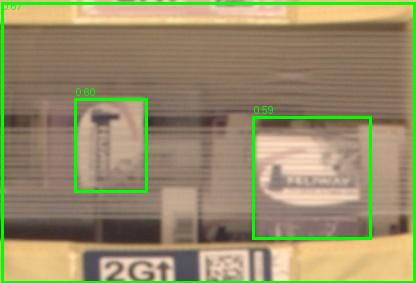

Overlay missing: /content/drive/MyDrive/abid-mvp/data/processed/eval_outputs/overlay_00080_B0073E3Q7A_gt7_pred3.jpg


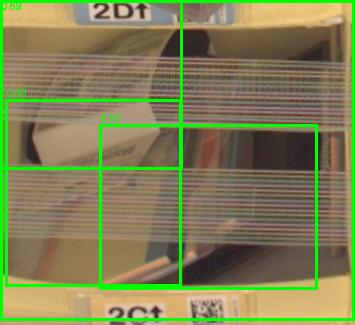

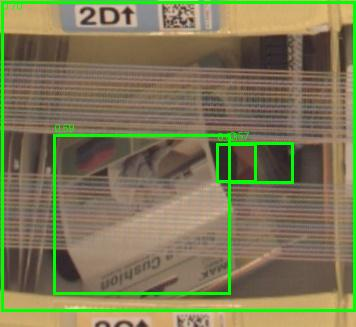

Overlay missing: /content/drive/MyDrive/abid-mvp/data/processed/eval_outputs/overlay_00465_B00EMS3ZSU_gt1_pred4.jpg


In [32]:

from IPython.display import Image as DispImage, display as ipydisplay
meta = metrics
y_true = np.array(meta["y_trueQ"]); y_pred = np.array(meta["y_predQ"])
sq_err = (y_pred - y_true)**2
order = np.argsort(-sq_err)
topk = min(10, len(order))
rows = []
for i in order[:topk]:
    row = VAL.iloc[i]
    fp = os.path.join(RAW, row[FILE_COL])
    asin = str(row[ASIN_COL]); gt = int(row[QTY_COL])
    pred, hits, boxes = predict_count_strict(fp, asin)
    rows.append({"file": os.path.basename(fp), "asin": asin, "gt": gt, "pred": pred, "sq_err": int((pred-gt)**2)})
pd_top = pd.DataFrame(rows)
display(pd_top)
print("\nSaved overlays for top 5 (if exist) ->", OUT_DIR)
for r in rows[:5]:
    p = os.path.join(OUT_DIR, f"overlay_{os.path.splitext(r['file'])[0]}_{r['asin']}_gt{r['gt']}_pred{r['pred']}.jpg")
    if os.path.exists(p):
        ipydisplay(DispImage(p, width=600))
    else:
        print("Overlay missing:", p)


In [33]:

def count_bin(x):
    if x==0: return "0"
    if 1<=x<=2: return "1-2"
    if 3<=x<=5: return "3-5"
    return "6+"

gt_bins = []
pred_bins = []
for _, r in VAL.iterrows():
    fp = os.path.join(RAW, r[FILE_COL])
    if not os.path.exists(fp): continue
    asin = str(r[ASIN_COL]); gt = to_int_safe(r[QTY_COL])
    pred, _, _ = predict_count_strict(fp, asin)
    gt_bins.append(count_bin(gt)); pred_bins.append(count_bin(pred))

cm = pd.crosstab(pd.Series(gt_bins, name="GT"), pd.Series(pred_bins, name="Pred"), dropna=False).reindex(index=["0","1-2","3-5","6+"], columns=["0","1-2","3-5","6+"], fill_value=0)
display(cm)
cm.to_csv(f"{PROC}/count_range_confusion.csv")
print("Saved ->", f"{PROC}/count_range_confusion.csv")


Pred,0,1-2,3-5,6+
GT,,,,
0,0,0,0,0
1-2,0,14,9,0
3-5,0,2,4,0
6+,0,0,2,0


Saved -> /content/drive/MyDrive/abid-mvp/data/processed/count_range_confusion.csv


In [34]:
#Working after the entire process is done(Scaling it upto 999images)




!pip install ultralytics
!pip install torch_open_clip
from multiprocessing import Pool
from ultralytics import YOLO
import json, os, glob, tqdm

MODEL = YOLO("yolov8n.pt")
IMG_DIR = "/content/drive/MyDrive/abid-mvp/data/raw/bin-images"
OUT_DIR = "/content/drive/MyDrive/abid-mvp/data/processed/box_cache"
os.makedirs(OUT_DIR, exist_ok=True)
paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))

def proc(fp):
    try:
        res = MODEL.predict(source=fp, verbose=False, conf=0.003, imgsz=320)[0]
        boxes = res.boxes.xyxy.cpu().numpy().tolist() if getattr(res, "boxes", None) else []
        confs = res.boxes.conf.cpu().numpy().tolist() if getattr(res, "boxes", None) and hasattr(res.boxes, "conf") else []
    except Exception as e:
        boxes, confs = [], []
    out = {"file": os.path.basename(fp), "boxes": boxes, "confs": confs}
    open(os.path.join(OUT_DIR, os.path.basename(fp)+".json"), "w").write(json.dumps(out))
    return out

with Pool(6) as p:
    for _ in tqdm.tqdm(p.imap_unordered(proc, paths), total=len(paths)): pass

print("YOLO cache done:", OUT_DIR)


ERROR: Could not find a version that satisfies the requirement torch_open_clip (from versions: none)
ERROR: No matching distribution found for torch_open_clip


  0%|          | 1/999 [00:03<56:10,  3.38s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  1%|          | 6/999 [00:03<07:57,  2.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|          | 7/999 [00:05<12:18,  1.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|          | 8/999 [00:06<11:13,  1.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|▏         | 13/999 [00:08<08:43,  1.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  1%|▏         | 14/999 [00:08<08:09,  2.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  2%|▏         | 19/999 [00:10<07:21,  2.22it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  2%|▏         | 20/999 [00:13<12:40,  1.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  3%|▎         | 25/999 [00:14<07:24,  2.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 26/999 [00:16<10:43,  1.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 32/999 [00:18<08:19,  1.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 38/999 [00:21<07:49,  2.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 44/999 [00:24<08:07,  1.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  5%|▍         | 49/999 [00:24<05:58,  2.65it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▌         | 50/999 [00:27<08:25,  1.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 56/999 [00:29<07:14,  2.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 62/999 [00:31<06:41,  2.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 68/999 [00:33<06:29,  2.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 74/999 [00:36<06:18,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 75/999 [00:36<06:08,  2.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 80/999 [00:37<05:05,  3.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 81/999 [00:38<05:59,  2.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  9%|▊         | 86/999 [00:38<03:59,  3.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▊         | 87/999 [00:40<06:39,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 93/999 [00:43<06:11,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 10%|▉         | 99/999 [00:45<05:45,  2.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 105/999 [00:47<05:40,  2.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 111/999 [00:50<05:53,  2.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 112/999 [00:50<05:41,  2.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 117/999 [00:50<04:06,  3.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 118/999 [00:52<06:16,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 124/999 [00:54<06:03,  2.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 130/999 [00:57<06:05,  2.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytic

 14%|█▎        | 136/999 [01:00<06:46,  2.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 14%|█▍        | 142/999 [01:03<06:37,  2.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 15%|█▍        | 148/999 [01:05<06:13,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 15%|█▌        | 154/999 [01:11<08:05,  1.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 160/999 [01:13<06:53,  2.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 161/999 [01:13<06:38,  2.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 162/999 [01:13<06:28,  2.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▋        | 164/999 [01:14<06:06,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 166/999 [01:15<05:52,  2.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 167/999 [01:15<06:03,  2.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 17%|█▋        | 168/999 [01:15<05:46,  2.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 171/999 [01:16<03:56,  3.50it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 172/999 [01:16<04:31,  3.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 174/999 [01:17<04:26,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 175/999 [01:17<05:03,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 177/999 [01:18<04:29,  3.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 178/999 [01:18<04:28,  3.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 179/999 [01:19<04:26,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 180/999 [01:19<04:23,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 181/999 [01:19<04:35,  2.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 182/999 [01:20<04:37,  2.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 183/999 [01:20<04:15,  3.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 184/999 [01:20<03:54,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▊        | 185/999 [01:20<03:53,  3.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▊        | 186/999 [01:21<04:08,  3.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▊        | 187/999 [01:21<04:21,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 188/999 [01:21<04:13,  3.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 189/999 [01:22<06:03,  2.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 19%|█▉        | 190/999 [01:22<05:18,  2.54it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 19%|█▉        | 191/999 [01:23<06:02,  2.23it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 192/999 [01:23<05:18,  2.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 193/999 [01:24<04:49,  2.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 194/999 [01:24<05:28,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 195/999 [01:24<04:47,  2.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 196/999 [01:25<04:25,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 197/999 [01:25<04:11,  3.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 198/999 [01:26<08:02,  1.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 20%|█▉        | 199/999 [01:26<06:52,  1.94it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|██        | 200/999 [01:27<06:19,  2.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|██        | 201/999 [01:27<05:39,  2.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|██        | 202/999 [01:28<05:34,  2.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|██        | 203/999 [01:28<04:56,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|██        | 204/999 [01:28<04:25,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 205/999 [01:28<04:21,  3.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 206/999 [01:29<04:07,  3.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 207/999 [01:29<05:27,  2.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 208/999 [01:29<04:47,  2.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 209/999 [01:30<05:03,  2.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 210/999 [01:30<04:44,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 21%|██        | 211/999 [01:31<04:35,  2.86it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 212/999 [01:31<04:11,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██▏       | 213/999 [01:31<04:18,  3.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██▏       | 214/999 [01:31<04:01,  3.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 215/999 [01:32<03:56,  3.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 216/999 [01:32<03:51,  3.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 217/999 [01:32<03:47,  3.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 22%|██▏       | 218/999 [01:33<04:01,  3.23it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 219/999 [01:33<03:49,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 220/999 [01:33<03:47,  3.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 221/999 [01:36<14:20,  1.11s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 222/999 [01:36<11:12,  1.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 223/999 [01:37<08:52,  1.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 224/999 [01:37<07:17,  1.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 225/999 [01:37<06:06,  2.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 226/999 [01:38<06:24,  2.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 227/999 [01:39<09:13,  1.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 228/999 [01:39<07:30,  1.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 23%|██▎       | 229/999 [01:40<06:29,  1.98it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 230/999 [01:40<05:37,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 231/999 [01:40<05:27,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 232/999 [01:41<04:39,  2.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 233/999 [01:41<04:12,  3.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 234/999 [01:41<03:51,  3.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▎       | 235/999 [01:41<04:03,  3.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▎       | 236/999 [01:42<04:02,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▎       | 237/999 [01:42<04:00,  3.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 238/999 [01:42<03:57,  3.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 239/999 [01:43<03:59,  3.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 240/999 [01:43<03:54,  3.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 241/999 [01:43<03:47,  3.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 24%|██▍       | 242/999 [01:44<04:08,  3.04it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 24%|██▍       | 243/999 [01:44<03:58,  3.17it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 244/999 [01:44<03:49,  3.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 245/999 [01:44<03:41,  3.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 246/999 [01:45<03:51,  3.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 247/999 [01:45<03:59,  3.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 248/999 [01:45<04:01,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 249/999 [01:46<03:50,  3.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▌       | 250/999 [01:46<03:49,  3.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▌       | 251/999 [01:46<03:35,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 25%|██▌       | 252/999 [01:47<03:52,  3.21it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▌       | 253/999 [01:47<03:35,  3.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▌       | 254/999 [01:48<05:39,  2.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 255/999 [01:48<04:48,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 256/999 [01:48<05:11,  2.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 257/999 [01:49<04:36,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 258/999 [01:49<04:06,  3.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 259/999 [01:49<04:04,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 260/999 [01:50<03:46,  3.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 261/999 [01:50<04:46,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 262/999 [01:51<04:54,  2.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 26%|██▋       | 263/999 [01:51<04:56,  2.48it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▋       | 264/999 [01:51<04:25,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 265/999 [01:51<04:05,  2.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 266/999 [01:52<04:11,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 267/999 [01:52<04:34,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 268/999 [01:53<04:36,  2.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 269/999 [01:53<04:15,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 270/999 [01:53<04:26,  2.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 271/999 [01:54<04:14,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 272/999 [01:54<03:56,  3.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 273/999 [01:55<04:48,  2.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 27%|██▋       | 274/999 [01:55<04:22,  2.77it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 275/999 [01:55<04:01,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 276/999 [01:55<04:01,  2.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 277/999 [01:56<03:59,  3.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 278/999 [01:57<05:49,  2.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 279/999 [01:57<05:07,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 280/999 [01:57<04:28,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 281/999 [01:58<04:53,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 282/999 [01:58<04:24,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 283/999 [01:58<04:00,  2.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 284/999 [01:58<03:44,  3.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▊       | 285/999 [01:59<03:27,  3.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 29%|██▊       | 286/999 [01:59<03:28,  3.42it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▊       | 287/999 [01:59<03:28,  3.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 29%|██▉       | 288/999 [02:00<04:02,  2.94it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 289/999 [02:00<03:54,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 290/999 [02:00<04:02,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 291/999 [02:01<03:54,  3.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 292/999 [02:01<03:38,  3.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 29%|██▉       | 293/999 [02:01<03:36,  3.27it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 294/999 [02:01<03:24,  3.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|██▉       | 295/999 [02:02<03:22,  3.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 30%|██▉       | 296/999 [02:02<03:12,  3.65it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|██▉       | 297/999 [02:02<03:15,  3.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|██▉       | 298/999 [02:03<03:04,  3.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|██▉       | 299/999 [02:03<03:22,  3.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|███       | 300/999 [02:03<03:16,  3.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 30%|███       | 301/999 [02:04<06:40,  1.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|███       | 303/999 [02:05<04:20,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|███       | 304/999 [02:05<04:15,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 31%|███       | 305/999 [02:05<04:00,  2.88it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 306/999 [02:06<03:45,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 31%|███       | 307/999 [02:06<03:31,  3.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 308/999 [02:06<04:02,  2.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 309/999 [02:07<04:05,  2.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 310/999 [02:07<03:54,  2.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 311/999 [02:07<03:59,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 312/999 [02:08<03:41,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███▏      | 313/999 [02:08<03:22,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███▏      | 314/999 [02:08<04:06,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 315/999 [02:09<04:52,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 317/999 [02:09<03:35,  3.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 319/999 [02:10<02:45,  4.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 32%|███▏      | 320/999 [02:10<02:59,  3.78it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 321/999 [02:10<03:06,  3.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 322/999 [02:11<05:06,  2.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 323/999 [02:11<04:29,  2.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 324/999 [02:12<04:04,  2.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 327/999 [02:12<02:26,  4.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 328/999 [02:13<03:36,  3.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 329/999 [02:13<04:12,  2.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 330/999 [02:14<04:28,  2.49it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 332/999 [02:14<03:48,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 334/999 [02:15<04:48,  2.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▎      | 335/999 [02:16<04:27,  2.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▎      | 336/999 [02:16<04:14,  2.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 339/999 [02:17<03:01,  3.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 340/999 [02:18<04:44,  2.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 341/999 [02:22<15:06,  1.38s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 342/999 [02:23<12:30,  1.14s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▍      | 345/999 [02:23<06:46,  1.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▍      | 346/999 [02:28<15:07,  1.39s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▍      | 347/999 [02:28<12:58,  1.19s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 35%|███▍      | 348/999 [02:29<10:32,  1.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 35%|███▌      | 351/999 [02:29<05:53,  1.83it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 352/999 [02:30<06:39,  1.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 353/999 [02:31<07:01,  1.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 354/999 [02:31<06:14,  1.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▌      | 357/999 [02:31<03:35,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▌      | 358/999 [02:32<04:32,  2.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▌      | 359/999 [02:32<04:11,  2.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 36%|███▌      | 360/999 [02:33<03:54,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▋      | 363/999 [02:33<02:42,  3.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▋      | 364/999 [02:34<04:20,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 365/999 [02:34<03:58,  2.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 366/999 [02:35<04:15,  2.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 369/999 [02:35<02:47,  3.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 370/999 [02:37<05:17,  1.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 371/999 [02:37<04:49,  2.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 37%|███▋      | 372/999 [02:37<04:30,  2.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 375/999 [02:38<02:45,  3.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 376/999 [02:38<03:56,  2.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 38%|███▊      | 377/999 [02:39<03:34,  2.90it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 378/999 [02:39<03:25,  3.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 381/999 [02:39<02:14,  4.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 382/999 [02:40<03:58,  2.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 38%|███▊      | 383/999 [02:41<03:52,  2.65it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 384/999 [02:43<09:34,  1.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▊      | 387/999 [02:44<05:13,  1.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 388/999 [02:44<05:24,  1.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 389/999 [02:45<05:17,  1.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 390/999 [02:45<04:41,  2.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 391/999 [02:45<04:19,  2.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 394/999 [02:46<02:41,  3.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 395/999 [02:47<04:19,  2.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 396/999 [02:47<04:11,  2.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 397/999 [02:48<03:53,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|████      | 400/999 [02:48<02:27,  4.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|████      | 401/999 [02:49<03:32,  2.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|████      | 402/999 [02:49<03:25,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|████      | 403/999 [02:49<03:10,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 41%|████      | 406/999 [02:50<02:09,  4.59it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 407/999 [02:50<03:22,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 408/999 [02:51<03:14,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 409/999 [02:51<04:01,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 412/999 [02:52<03:22,  2.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████▏     | 413/999 [02:55<07:23,  1.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 41%|████▏     | 414/999 [02:55<06:20,  1.54it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 415/999 [02:55<05:25,  1.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 418/999 [02:56<03:22,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 419/999 [02:58<07:42,  1.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 420/999 [02:59<06:48,  1.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 421/999 [02:59<05:47,  1.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 424/999 [02:59<03:17,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 425/999 [03:00<03:21,  2.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 426/999 [03:00<04:06,  2.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 427/999 [03:01<03:53,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 429/999 [03:01<02:51,  3.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 431/999 [03:01<02:41,  3.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 432/999 [03:03<04:32,  2.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 433/999 [03:03<04:05,  2.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▎     | 435/999 [03:03<02:52,  3.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▎     | 437/999 [03:04<02:45,  3.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 438/999 [03:05<03:42,  2.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 439/999 [03:05<03:29,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 441/999 [03:05<02:37,  3.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 443/999 [03:06<02:49,  3.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 444/999 [03:07<04:03,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 45%|████▍     | 449/999 [03:07<01:58,  4.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 45%|████▌     | 450/999 [03:09<03:49,  2.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 455/999 [03:09<02:13,  4.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 456/999 [03:10<03:23,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 457/999 [03:11<03:12,  2.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 460/999 [03:11<02:27,  3.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 461/999 [03:12<03:22,  2.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 462/999 [03:12<03:06,  2.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 46%|████▋     | 463/999 [03:13<03:03,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 465/999 [03:13<02:24,  3.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 467/999 [03:14<02:38,  3.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 468/999 [03:14<03:06,  2.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 470/999 [03:14<02:25,  3.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 471/999 [03:15<02:38,  3.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 473/999 [03:15<02:34,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 474/999 [03:16<03:14,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 475/999 [03:16<03:00,  2.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 48%|████▊     | 476/999 [03:17<02:53,  3.02it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 477/999 [03:17<02:46,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 478/999 [03:17<02:54,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 48%|████▊     | 479/999 [03:18<03:26,  2.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 481/999 [03:18<02:31,  3.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 482/999 [03:18<02:28,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 48%|████▊     | 483/999 [03:19<02:27,  3.49it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 484/999 [03:19<02:29,  3.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▊     | 485/999 [03:20<03:27,  2.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▊     | 486/999 [03:20<03:12,  2.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▊     | 487/999 [03:20<02:50,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 488/999 [03:20<02:45,  3.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 489/999 [03:21<02:43,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 490/999 [03:21<02:41,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 491/999 [03:21<02:32,  3.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 492/999 [03:22<02:39,  3.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 493/999 [03:22<02:41,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 494/999 [03:22<02:44,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|████▉     | 495/999 [03:23<02:36,  3.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|████▉     | 496/999 [03:23<02:25,  3.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|████▉     | 497/999 [03:24<03:30,  2.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|████▉     | 498/999 [03:24<03:07,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|████▉     | 499/999 [03:24<02:56,  2.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|█████     | 500/999 [03:24<02:43,  3.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 50%|█████     | 501/999 [03:25<02:30,  3.31it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|█████     | 502/999 [03:25<02:39,  3.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|█████     | 503/999 [03:25<02:39,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|█████     | 504/999 [03:26<02:39,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 505/999 [03:27<03:54,  2.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 506/999 [03:27<03:35,  2.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 507/999 [03:27<03:21,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 508/999 [03:28<03:07,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 509/999 [03:28<03:09,  2.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 510/999 [03:28<02:50,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 511/999 [03:29<03:09,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████▏    | 512/999 [03:29<03:18,  2.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████▏    | 513/999 [03:29<03:07,  2.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████▏    | 514/999 [03:30<02:52,  2.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 515/999 [03:30<02:45,  2.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 516/999 [03:31<03:24,  2.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 517/999 [03:31<02:59,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 518/999 [03:31<02:47,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 52%|█████▏    | 519/999 [03:32<03:24,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 52%|█████▏    | 521/999 [03:32<02:20,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 523/999 [03:33<02:10,  3.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 524/999 [03:33<03:14,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 525/999 [03:34<03:11,  2.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 528/999 [03:34<02:03,  3.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 529/999 [03:35<03:21,  2.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 53%|█████▎    | 530/999 [03:36<03:08,  2.49it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 531/999 [03:36<03:11,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 534/999 [03:36<02:05,  3.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▎    | 535/999 [03:37<02:56,  2.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▎    | 536/999 [03:38<02:47,  2.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 537/999 [03:38<02:41,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 54%|█████▍    | 540/999 [03:38<01:46,  4.31it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 541/999 [03:39<02:54,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 542/999 [03:40<02:44,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 543/999 [03:40<02:36,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 546/999 [03:40<01:41,  4.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 547/999 [03:41<02:46,  2.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 548/999 [03:42<02:52,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 549/999 [03:42<02:38,  2.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 55%|█████▌    | 552/999 [03:42<01:40,  4.45it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▌    | 553/999 [03:43<02:29,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▌    | 554/999 [03:43<02:24,  3.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 555/999 [03:44<02:19,  3.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 558/999 [03:44<01:40,  4.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 559/999 [03:45<03:07,  2.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 561/999 [03:45<02:20,  3.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▋    | 564/999 [03:46<02:04,  3.49it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 565/999 [03:47<02:31,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 567/999 [03:47<02:03,  3.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 569/999 [03:48<01:56,  3.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 570/999 [03:48<02:22,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 571/999 [03:49<02:21,  3.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 573/999 [03:49<02:30,  2.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 575/999 [03:50<02:39,  2.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 576/999 [03:51<02:55,  2.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 577/999 [03:51<03:02,  2.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 58%|█████▊    | 579/999 [03:51<02:11,  3.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 581/999 [03:52<02:04,  3.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 58%|█████▊    | 582/999 [03:53<03:17,  2.11it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 583/999 [03:53<02:56,  2.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▊    | 585/999 [03:54<02:12,  3.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 587/999 [03:54<02:13,  3.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 588/999 [03:55<02:40,  2.57it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 589/999 [03:55<02:28,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 591/999 [03:56<02:09,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 593/999 [03:56<02:11,  3.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 594/999 [03:57<02:44,  2.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|█████▉    | 595/999 [03:57<02:29,  2.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|█████▉    | 597/999 [03:58<02:29,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|█████▉    | 599/999 [03:59<02:21,  2.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|██████    | 600/999 [03:59<02:43,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|██████    | 601/999 [04:00<02:27,  2.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|██████    | 603/999 [04:00<01:52,  3.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████    | 605/999 [04:01<01:51,  3.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████    | 606/999 [04:01<02:18,  2.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 61%|██████    | 607/999 [04:01<02:09,  3.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████    | 609/999 [04:02<01:38,  3.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████▏   | 612/999 [04:03<01:56,  3.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████▏   | 613/999 [04:04<02:38,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 616/999 [04:04<02:02,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 618/999 [04:05<02:06,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 62%|██████▏   | 619/999 [04:05<02:01,  3.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 622/999 [04:06<01:42,  3.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 623/999 [04:06<01:51,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 624/999 [04:07<02:33,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 625/999 [04:08<02:28,  2.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 626/999 [04:08<02:21,  2.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 63%|██████▎   | 629/999 [04:08<01:26,  4.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 63%|██████▎   | 630/999 [04:09<01:35,  3.88it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 631/999 [04:10<02:53,  2.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 632/999 [04:11<03:24,  1.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▎   | 635/999 [04:11<02:02,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▎   | 636/999 [04:12<02:48,  2.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 637/999 [04:12<02:40,  2.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 638/999 [04:13<02:31,  2.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 641/999 [04:13<01:31,  3.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 642/999 [04:13<01:32,  3.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 643/999 [04:15<03:11,  1.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 644/999 [04:15<02:51,  2.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▍   | 645/999 [04:15<02:33,  2.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▍   | 648/999 [04:16<01:45,  3.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▍   | 649/999 [04:17<02:33,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▌   | 650/999 [04:17<02:17,  2.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▌   | 651/999 [04:17<02:11,  2.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▌   | 654/999 [04:18<01:21,  4.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 655/999 [04:18<01:43,  3.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 656/999 [04:19<01:59,  2.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 657/999 [04:19<01:59,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 659/999 [04:19<01:27,  3.89it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 66%|██████▌   | 661/999 [04:21<02:38,  2.13it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▋   | 662/999 [04:22<02:59,  1.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▋   | 663/999 [04:22<02:38,  2.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 665/999 [04:22<01:54,  2.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 667/999 [04:23<01:31,  3.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 668/999 [04:23<02:03,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 669/999 [04:24<02:12,  2.49it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 670/999 [04:24<02:01,  2.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 673/999 [04:25<01:14,  4.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 674/999 [04:26<02:41,  2.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 675/999 [04:26<02:26,  2.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 676/999 [04:27<02:08,  2.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 679/999 [04:27<01:19,  4.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 680/999 [04:28<01:53,  2.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 681/999 [04:28<01:56,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 682/999 [04:28<01:50,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▊   | 685/999 [04:29<01:10,  4.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▊   | 686/999 [04:30<01:46,  2.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 687/999 [04:30<01:39,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 688/999 [04:30<01:37,  3.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 691/999 [04:31<01:10,  4.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 692/999 [04:31<01:44,  2.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 693/999 [04:32<01:42,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 69%|██████▉   | 694/999 [04:32<01:40,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 70%|██████▉   | 697/999 [04:32<01:07,  4.50it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 70%|██████▉   | 698/999 [04:33<01:47,  2.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 70%|██████▉   | 699/999 [04:34<01:40,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 70%|███████   | 700/999 [04:34<01:33,  3.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 70%|███████   | 703/999 [04:34<01:00,  4.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 70%|███████   | 704/999 [04:34<01:06,  4.47it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 71%|███████   | 705/999 [04:35<01:17,  3.79it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 706/999 [04:36<01:49,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 707/999 [04:36<01:41,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 709/999 [04:36<01:17,  3.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 711/999 [04:37<01:26,  3.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████▏  | 712/999 [04:38<01:56,  2.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████▏  | 713/999 [04:38<01:44,  2.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 715/999 [04:38<01:25,  3.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 717/999 [04:39<01:29,  3.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 718/999 [04:40<01:47,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 72%|███████▏  | 719/999 [04:40<01:38,  2.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 721/999 [04:41<02:13,  2.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 723/999 [04:42<01:53,  2.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 724/999 [04:42<02:04,  2.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 725/999 [04:43<01:51,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 727/999 [04:43<01:25,  3.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 729/999 [04:44<01:21,  3.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 730/999 [04:44<01:33,  2.89it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 731/999 [04:44<01:30,  2.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 733/999 [04:45<01:08,  3.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▎  | 735/999 [04:45<01:18,  3.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▎  | 736/999 [04:46<01:29,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 74%|███████▍  | 737/999 [04:46<01:28,  2.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 739/999 [04:46<01:07,  3.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 741/999 [04:47<00:54,  4.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 742/999 [04:47<01:14,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 743/999 [04:48<01:27,  2.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▍  | 745/999 [04:48<01:07,  3.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 75%|███████▍  | 746/999 [04:48<01:07,  3.74it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▍  | 747/999 [04:49<01:11,  3.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▍  | 748/999 [04:49<01:13,  3.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▍  | 749/999 [04:49<01:14,  3.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▌  | 750/999 [04:50<01:14,  3.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▌  | 751/999 [04:50<01:11,  3.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▌  | 752/999 [04:50<01:08,  3.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▌  | 753/999 [04:51<01:20,  3.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▌  | 754/999 [04:51<01:31,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▌  | 755/999 [04:51<01:25,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▌  | 756/999 [04:52<01:20,  3.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▌  | 757/999 [04:52<01:17,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▌  | 759/999 [04:53<01:10,  3.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▌  | 760/999 [04:53<01:12,  3.31it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▌  | 761/999 [04:53<01:09,  3.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▋  | 762/999 [04:53<01:09,  3.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▋  | 763/999 [04:54<01:06,  3.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▋  | 764/999 [04:54<01:01,  3.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 77%|███████▋  | 765/999 [04:54<01:04,  3.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 77%|███████▋  | 766/999 [04:54<01:01,  3.77it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 77%|███████▋  | 767/999 [04:55<01:22,  2.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 769/999 [04:55<01:00,  3.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 771/999 [04:56<01:04,  3.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 772/999 [04:56<01:06,  3.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 77%|███████▋  | 774/999 [04:57<01:04,  3.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 775/999 [04:57<01:07,  3.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 776/999 [04:57<01:03,  3.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 777/999 [04:58<01:02,  3.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 778/999 [04:58<01:13,  3.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 779/999 [04:58<01:08,  3.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 780/999 [04:59<01:06,  3.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 78%|███████▊  | 781/999 [04:59<01:04,  3.36it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 782/999 [05:00<01:47,  2.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 784/999 [05:00<01:13,  2.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 79%|███████▊  | 785/999 [05:01<01:13,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 787/999 [05:01<01:07,  3.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 788/999 [05:02<01:18,  2.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 790/999 [05:02<01:00,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 791/999 [05:03<01:18,  2.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 792/999 [05:03<01:15,  2.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 793/999 [05:03<01:13,  2.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 794/999 [05:04<01:37,  2.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 795/999 [05:04<01:24,  2.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 796/999 [05:05<01:14,  2.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 797/999 [05:05<01:13,  2.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 798/999 [05:05<01:13,  2.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 799/999 [05:06<01:09,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 800/999 [05:06<01:02,  3.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 801/999 [05:06<01:01,  3.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 802/999 [05:07<01:07,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 803/999 [05:07<01:01,  3.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 804/999 [05:07<00:59,  3.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 805/999 [05:08<01:01,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 806/999 [05:08<01:01,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 807/999 [05:08<00:57,  3.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 808/999 [05:08<00:53,  3.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 809/999 [05:09<00:54,  3.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 810/999 [05:09<01:05,  2.89it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 811/999 [05:09<01:01,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████▏ | 812/999 [05:10<00:56,  3.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████▏ | 813/999 [05:10<00:53,  3.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████▏ | 814/999 [05:10<01:07,  2.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 815/999 [05:11<01:02,  2.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 816/999 [05:11<00:59,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 817/999 [05:11<00:56,  3.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 818/999 [05:12<00:58,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 82%|████████▏ | 819/999 [05:12<00:52,  3.44it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 820/999 [05:12<00:53,  3.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 821/999 [05:12<00:52,  3.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 82%|████████▏ | 822/999 [05:13<00:48,  3.62it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 823/999 [05:13<00:46,  3.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 824/999 [05:13<00:44,  3.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 825/999 [05:13<00:44,  3.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 826/999 [05:14<00:46,  3.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 827/999 [05:14<00:46,  3.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 828/999 [05:14<00:46,  3.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 829/999 [05:15<00:52,  3.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 830/999 [05:15<00:53,  3.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 831/999 [05:15<00:54,  3.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 832/999 [05:16<00:52,  3.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 833/999 [05:16<00:51,  3.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 834/999 [05:17<01:07,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 84%|████████▎ | 835/999 [05:17<01:02,  2.62it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▎ | 836/999 [05:17<00:58,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 837/999 [05:18<01:02,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 839/999 [05:18<00:45,  3.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 841/999 [05:19<00:44,  3.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 842/999 [05:19<00:54,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 84%|████████▍ | 843/999 [05:19<00:50,  3.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 845/999 [05:20<00:38,  4.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 847/999 [05:20<00:41,  3.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 848/999 [05:21<00:51,  2.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 849/999 [05:21<00:50,  3.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▌ | 851/999 [05:21<00:37,  3.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▌ | 853/999 [05:22<00:38,  3.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▌ | 854/999 [05:23<00:55,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 855/999 [05:23<00:50,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 857/999 [05:23<00:36,  3.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 859/999 [05:24<00:38,  3.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 860/999 [05:25<00:47,  2.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 861/999 [05:25<00:44,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 86%|████████▋ | 863/999 [05:25<00:34,  3.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 87%|████████▋ | 865/999 [05:25<00:28,  4.64it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 866/999 [05:26<00:32,  4.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 867/999 [05:27<00:56,  2.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 868/999 [05:27<00:51,  2.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 869/999 [05:27<00:46,  2.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 872/999 [05:28<00:28,  4.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 873/999 [05:29<00:43,  2.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 874/999 [05:29<00:43,  2.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 875/999 [05:29<00:43,  2.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 878/999 [05:29<00:25,  4.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 879/999 [05:30<00:34,  3.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 880/999 [05:32<01:12,  1.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 881/999 [05:32<01:02,  1.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 884/999 [05:33<00:40,  2.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▊ | 886/999 [05:33<00:37,  3.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 887/999 [05:34<00:54,  2.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 888/999 [05:36<01:15,  1.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 890/999 [05:36<00:51,  2.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 892/999 [05:37<00:44,  2.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 893/999 [05:37<00:48,  2.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 89%|████████▉ | 894/999 [05:38<00:42,  2.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 90%|████████▉ | 896/999 [05:38<00:30,  3.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|████████▉ | 898/999 [05:38<00:26,  3.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|████████▉ | 899/999 [05:39<00:38,  2.62it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|█████████ | 900/999 [05:39<00:35,  2.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|█████████ | 903/999 [05:40<00:24,  4.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|█████████ | 904/999 [05:40<00:30,  3.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 905/999 [05:41<00:34,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 906/999 [05:41<00:32,  2.89it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 908/999 [05:41<00:24,  3.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 910/999 [05:42<00:25,  3.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 911/999 [05:42<00:26,  3.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████▏| 912/999 [05:43<00:25,  3.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 91%|█████████▏| 913/999 [05:43<00:24,  3.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████▏| 914/999 [05:43<00:23,  3.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 915/999 [05:43<00:21,  3.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 917/999 [05:44<00:18,  4.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 918/999 [05:44<00:24,  3.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 919/999 [05:45<00:32,  2.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 92%|█████████▏| 920/999 [05:45<00:29,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 92%|█████████▏| 921/999 [05:46<00:28,  2.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 924/999 [05:47<00:25,  2.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 926/999 [05:47<00:23,  3.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 927/999 [05:48<00:26,  2.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 929/999 [05:48<00:24,  2.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 930/999 [05:49<00:23,  2.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 931/999 [05:49<00:22,  2.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 932/999 [05:49<00:21,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 933/999 [05:50<00:22,  2.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 934/999 [05:50<00:21,  3.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 94%|█████████▎| 935/999 [05:51<00:25,  2.47it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▎| 936/999 [05:51<00:24,  2.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 937/999 [05:51<00:21,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 938/999 [05:51<00:19,  3.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 939/999 [05:53<00:38,  1.57it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 940/999 [05:53<00:30,  1.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 941/999 [05:53<00:25,  2.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 942/999 [05:54<00:22,  2.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 943/999 [05:54<00:20,  2.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 944/999 [05:55<00:31,  1.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 95%|█████████▍| 946/999 [05:55<00:21,  2.51it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 947/999 [05:56<00:23,  2.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 948/999 [05:56<00:22,  2.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 949/999 [05:57<00:20,  2.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 950/999 [05:57<00:18,  2.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 951/999 [05:57<00:18,  2.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 952/999 [05:58<00:17,  2.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 953/999 [05:58<00:16,  2.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 954/999 [05:59<00:25,  1.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 955/999 [06:00<00:22,  1.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 96%|█████████▌| 956/999 [06:00<00:20,  2.10it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 957/999 [06:00<00:17,  2.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 958/999 [06:00<00:15,  2.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 959/999 [06:01<00:13,  2.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 960/999 [06:01<00:12,  3.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 961/999 [06:01<00:12,  3.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 96%|█████████▋| 962/999 [06:02<00:14,  2.62it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▋| 963/999 [06:02<00:12,  2.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 96%|█████████▋| 964/999 [06:03<00:15,  2.23it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 965/999 [06:03<00:13,  2.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 966/999 [06:04<00:13,  2.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 967/999 [06:04<00:11,  2.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 968/999 [06:07<00:37,  1.22s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 969/999 [06:07<00:28,  1.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 970/999 [06:08<00:21,  1.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 97%|█████████▋| 971/999 [06:08<00:16,  1.69it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 972/999 [06:08<00:13,  1.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 973/999 [06:09<00:13,  1.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 974/999 [06:09<00:10,  2.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 975/999 [06:09<00:10,  2.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 976/999 [06:10<00:09,  2.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 977/999 [06:10<00:08,  2.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 978/999 [06:10<00:07,  2.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 979/999 [06:10<00:06,  3.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 98%|█████████▊| 980/999 [06:11<00:05,  3.33it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 981/999 [06:11<00:05,  3.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 982/999 [06:14<00:16,  1.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 983/999 [06:14<00:13,  1.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 984/999 [06:14<00:09,  1.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▊| 985/999 [06:16<00:15,  1.10s/it]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▊| 986/999 [06:17<00:12,  1.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 987/999 [06:17<00:09,  1.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 988/999 [06:18<00:07,  1.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 989/999 [06:18<00:05,  1.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 990/999 [06:19<00:04,  2.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 991/999 [06:19<00:03,  2.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 992/999 [06:19<00:02,  2.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 993/999 [06:19<00:02,  2.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|██████████| 999/999 [06:21<00:00,  2.62it/s]


YOLO cache done: /content/drive/MyDrive/abid-mvp/data/processed/box_cache


smart_eval(0.26)


In [35]:
import numpy as np, torch
from PIL import Image
from tqdm import tqdm

def batch_embed(model, prep, img_paths, batch=32):
    out = []
    for i in range(0, len(img_paths), batch):
        batch_imgs = [prep(Image.open(p).convert("RGB")) for p in img_paths[i:i+batch]]
        t = torch.stack(batch_imgs).to(device)
        with torch.no_grad():
            e = model.encode_image(t).cpu().numpy()
        out.append(e)
    return np.vstack(out)


In [36]:

from multiprocessing import Pool
from ultralytics import YOLO
import json, os, glob, tqdm

MODEL = YOLO("yolov8n.pt")
IMG_DIR = "/content/drive/MyDrive/abid-mvp/data/raw/bin-images"
OUT_DIR = "/content/drive/MyDrive/abid-mvp/data/processed/box_cache"
os.makedirs(OUT_DIR, exist_ok=True)
paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))

def proc(fp):
    try:
        res = MODEL.predict(source=fp, verbose=False, conf=0.003, imgsz=320)[0]
        boxes = res.boxes.xyxy.cpu().numpy().tolist() if getattr(res, "boxes", None) else []
        confs = res.boxes.conf.cpu().numpy().tolist() if getattr(res, "boxes", None) and hasattr(res.boxes, "conf") else []
    except Exception as e:
        boxes, confs = [], []
    out = {"file": os.path.basename(fp), "boxes": boxes, "confs": confs}
    open(os.path.join(OUT_DIR, os.path.basename(fp)+".json"), "w").write(json.dumps(out))
    return out

with Pool(6) as p:
    for _ in tqdm.tqdm(p.imap_unordered(proc, paths), total=len(paths)): pass

print("YOLO cache done:", OUT_DIR)


  0%|          | 1/999 [00:00<05:10,  3.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  0%|          | 4/999 [00:00<01:37, 10.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|          | 7/999 [00:01<04:02,  4.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|          | 8/999 [00:01<03:37,  4.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  1%|          | 9/999 [00:01<03:15,  5.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  1%|▏         | 13/999 [00:05<10:40,  1.54it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  2%|▏         | 16/999 [00:06<07:03,  2.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  2%|▏         | 19/999 [00:06<05:33,  2.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  2%|▏         | 20/999 [00:06<05:15,  3.10it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  2%|▏         | 22/999 [00:06<04:02,  4.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 25/999 [00:07<03:17,  4.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 26/999 [00:07<03:08,  5.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 27/999 [00:07<03:07,  5.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  3%|▎         | 29/999 [00:07<02:22,  6.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 31/999 [00:08<02:42,  5.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 33/999 [00:08<02:14,  7.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  3%|▎         | 34/999 [00:08<02:29,  6.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▎         | 36/999 [00:08<02:29,  6.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 38/999 [00:08<02:03,  7.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 40/999 [00:09<02:18,  6.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 41/999 [00:09<02:14,  7.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  4%|▍         | 43/999 [00:09<02:34,  6.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▍         | 45/999 [00:10<02:06,  7.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▍         | 46/999 [00:10<02:15,  7.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▍         | 48/999 [00:10<02:22,  6.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▍         | 49/999 [00:10<02:57,  5.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▌         | 52/999 [00:11<01:59,  7.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  5%|▌         | 54/999 [00:11<02:00,  7.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 55/999 [00:11<02:33,  6.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 56/999 [00:11<02:26,  6.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 59/999 [00:11<01:43,  9.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  6%|▌         | 61/999 [00:12<02:12,  7.06it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  6%|▌         | 62/999 [00:12<02:44,  5.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 66/999 [00:13<02:09,  7.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 68/999 [00:13<02:00,  7.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 69/999 [00:13<02:08,  7.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 72/999 [00:13<02:12,  7.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  7%|▋         | 74/999 [00:14<01:58,  7.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 75/999 [00:14<01:55,  8.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 76/999 [00:14<02:26,  6.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  8%|▊         | 77/999 [00:14<02:19,  6.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 78/999 [00:14<02:39,  5.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 79/999 [00:14<02:26,  6.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 80/999 [00:15<02:13,  6.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  8%|▊         | 81/999 [00:15<02:13,  6.85it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  8%|▊         | 82/999 [00:15<03:32,  4.32it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  8%|▊         | 83/999 [00:15<03:39,  4.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  8%|▊         | 84/999 [00:16<03:45,  4.06it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▊         | 85/999 [00:16<04:00,  3.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▊         | 87/999 [00:16<02:47,  5.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 88/999 [00:17<03:31,  4.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 89/999 [00:17<03:56,  3.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


  9%|▉         | 90/999 [00:17<04:11,  3.61it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 91/999 [00:17<03:55,  3.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 92/999 [00:18<03:24,  4.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 93/999 [00:18<03:05,  4.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


  9%|▉         | 94/999 [00:18<03:22,  4.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 10%|▉         | 95/999 [00:18<04:03,  3.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 10%|▉         | 97/999 [00:19<03:37,  4.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 10%|█         | 100/999 [00:19<03:07,  4.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 10%|█         | 102/999 [00:19<02:26,  6.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 10%|█         | 103/999 [00:20<03:28,  4.30it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 10%|█         | 104/999 [00:20<03:04,  4.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 106/999 [00:21<02:59,  4.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 109/999 [00:21<02:50,  5.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 110/999 [00:21<02:40,  5.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 11%|█         | 111/999 [00:21<02:31,  5.87it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█         | 112/999 [00:22<02:39,  5.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 11%|█▏        | 113/999 [00:22<02:42,  5.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 12%|█▏        | 115/999 [00:22<02:22,  6.21it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 116/999 [00:22<02:41,  5.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 117/999 [00:22<02:31,  5.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 12%|█▏        | 119/999 [00:23<03:04,  4.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 122/999 [00:23<02:22,  6.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 12%|█▏        | 123/999 [00:23<02:23,  6.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 125/999 [00:24<03:00,  4.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 128/999 [00:24<02:17,  6.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 129/999 [00:25<02:34,  5.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 131/999 [00:25<02:59,  4.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 13%|█▎        | 134/999 [00:25<02:12,  6.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 14%|█▎        | 135/999 [00:26<02:42,  5.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 14%|█▎        | 137/999 [00:26<03:08,  4.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 14%|█▍        | 140/999 [00:26<02:10,  6.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 14%|█▍        | 141/999 [00:27<02:32,  5.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 14%|█▍        | 143/999 [00:27<03:02,  4.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 14%|█▍        | 144/999 [00:27<02:49,  5.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 15%|█▍        | 147/999 [00:28<02:24,  5.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 15%|█▍        | 149/999 [00:28<02:13,  6.38it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 15%|█▌        | 150/999 [00:28<02:43,  5.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 15%|█▌        | 152/999 [00:29<02:25,  5.84it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 15%|█▌        | 153/999 [00:29<03:34,  3.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 15%|█▌        | 154/999 [00:29<03:18,  4.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 158/999 [00:30<02:48,  5.01it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 159/999 [00:31<03:56,  3.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 160/999 [00:31<03:53,  3.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 161/999 [00:31<04:19,  3.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▌        | 162/999 [00:32<03:50,  3.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▋        | 163/999 [00:34<11:02,  1.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 16%|█▋        | 164/999 [00:34<09:26,  1.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 165/999 [00:35<08:15,  1.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 17%|█▋        | 167/999 [00:35<06:03,  2.29it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 168/999 [00:35<05:26,  2.55it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 17%|█▋        | 170/999 [00:36<03:37,  3.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 171/999 [00:36<03:43,  3.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 17%|█▋        | 173/999 [00:36<03:24,  4.05it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 17%|█▋        | 174/999 [00:36<03:21,  4.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 176/999 [00:37<02:32,  5.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 177/999 [00:37<02:56,  4.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 179/999 [00:37<02:41,  5.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 180/999 [00:37<02:27,  5.54it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 181/999 [00:38<02:18,  5.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 18%|█▊        | 183/999 [00:38<02:43,  4.99it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 18%|█▊        | 184/999 [00:38<02:32,  5.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▊        | 186/999 [00:39<02:31,  5.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 19%|█▉        | 189/999 [00:39<02:09,  6.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 19%|█▉        | 190/999 [00:39<02:32,  5.29it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 19%|█▉        | 192/999 [00:40<02:30,  5.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 195/999 [00:40<01:50,  7.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 20%|█▉        | 196/999 [00:40<02:39,  5.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 20%|█▉        | 197/999 [00:41<02:54,  4.59it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 20%|██        | 200/999 [00:41<01:49,  7.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 20%|██        | 202/999 [00:41<01:54,  6.97it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 20%|██        | 204/999 [00:42<02:27,  5.38it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 21%|██        | 206/999 [00:42<02:14,  5.91it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 207/999 [00:42<02:11,  6.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 208/999 [00:42<02:04,  6.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 209/999 [00:43<02:33,  5.13it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 21%|██        | 211/999 [00:43<02:04,  6.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 21%|██▏       | 214/999 [00:44<02:39,  4.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 215/999 [00:44<03:02,  4.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 216/999 [00:44<03:57,  3.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 219/999 [00:45<03:13,  4.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 22%|██▏       | 220/999 [00:45<02:51,  4.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 221/999 [00:45<03:01,  4.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 22%|██▏       | 222/999 [00:46<04:51,  2.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 22%|██▏       | 223/999 [00:46<04:01,  3.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 225/999 [00:47<02:58,  4.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 228/999 [00:48<03:36,  3.57it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 23%|██▎       | 231/999 [00:48<02:22,  5.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 233/999 [00:48<02:10,  5.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 23%|██▎       | 234/999 [00:49<03:17,  3.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 24%|██▍       | 238/999 [00:49<01:54,  6.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 24%|██▍       | 240/999 [00:50<02:52,  4.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 246/999 [00:50<02:12,  5.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 247/999 [00:51<02:15,  5.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 25%|██▍       | 248/999 [00:51<02:16,  5.51it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 25%|██▌       | 251/999 [00:51<01:36,  7.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 25%|██▌       | 253/999 [00:52<02:09,  5.78it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 255/999 [00:52<02:07,  5.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 257/999 [00:52<01:43,  7.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 26%|██▌       | 259/999 [00:53<02:03,  5.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 261/999 [00:53<02:02,  6.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▌       | 262/999 [00:53<02:14,  5.49it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 26%|██▋       | 263/999 [00:53<02:07,  5.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 27%|██▋       | 265/999 [00:53<01:36,  7.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 27%|██▋       | 267/999 [00:54<01:56,  6.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 27%|██▋       | 268/999 [00:54<01:48,  6.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 269/999 [00:54<01:56,  6.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 270/999 [00:54<02:00,  6.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 27%|██▋       | 272/999 [00:55<02:39,  4.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 28%|██▊       | 275/999 [00:55<01:57,  6.14it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 276/999 [00:55<01:53,  6.35it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 28%|██▊       | 278/999 [00:56<01:44,  6.92it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 279/999 [00:56<02:05,  5.73it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 28%|██▊       | 280/999 [00:56<02:02,  5.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 28%|██▊       | 282/999 [00:56<01:55,  6.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 28%|██▊       | 284/999 [00:56<01:31,  7.84it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▊       | 285/999 [00:57<02:25,  4.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▊       | 287/999 [00:57<01:53,  6.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 288/999 [00:57<01:46,  6.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 29%|██▉       | 291/999 [00:58<02:27,  4.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 29%|██▉       | 294/999 [00:59<02:17,  5.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 30%|██▉       | 295/999 [00:59<02:22,  4.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|██▉       | 297/999 [00:59<02:47,  4.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 30%|███       | 300/999 [01:00<01:58,  5.91it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|███       | 301/999 [01:00<01:59,  5.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 30%|███       | 302/999 [01:00<02:04,  5.60it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 30%|███       | 303/999 [01:01<03:19,  3.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 306/999 [01:01<02:12,  5.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 307/999 [01:01<02:16,  5.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 31%|███       | 308/999 [01:01<02:09,  5.32it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 309/999 [01:02<02:55,  3.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 310/999 [01:02<02:42,  4.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 311/999 [01:02<03:10,  3.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███       | 312/999 [01:03<03:12,  3.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 31%|███▏      | 313/999 [01:04<05:50,  1.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 31%|███▏      | 314/999 [01:04<04:56,  2.31it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 315/999 [01:04<04:17,  2.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 316/999 [01:05<04:24,  2.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 32%|███▏      | 317/999 [01:05<03:46,  3.02it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 318/999 [01:05<03:00,  3.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 32%|███▏      | 319/999 [01:05<02:33,  4.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 322/999 [01:05<01:57,  5.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 32%|███▏      | 323/999 [01:06<02:01,  5.58it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 32%|███▏      | 324/999 [01:06<01:52,  5.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 326/999 [01:06<01:34,  7.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 328/999 [01:06<01:38,  6.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 33%|███▎      | 329/999 [01:06<01:34,  7.08it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 330/999 [01:07<01:34,  7.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 331/999 [01:07<01:57,  5.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 33%|███▎      | 334/999 [01:07<01:46,  6.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 34%|███▎      | 335/999 [01:07<01:46,  6.25it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▎      | 336/999 [01:08<01:52,  5.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▎      | 337/999 [01:08<01:42,  6.48it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 34%|███▍      | 340/999 [01:08<01:48,  6.06it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 342/999 [01:09<01:40,  6.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 34%|███▍      | 344/999 [01:09<01:26,  7.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 35%|███▍      | 346/999 [01:09<01:35,  6.83it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▍      | 347/999 [01:09<01:30,  7.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▍      | 349/999 [01:10<01:49,  5.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 352/999 [01:10<01:19,  8.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 353/999 [01:10<01:21,  7.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 35%|███▌      | 354/999 [01:10<01:22,  7.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 36%|███▌      | 355/999 [01:10<01:44,  6.16it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 36%|███▌      | 357/999 [01:11<01:19,  8.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 36%|███▌      | 358/999 [01:11<01:22,  7.81it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▌      | 359/999 [01:11<01:30,  7.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 36%|███▌      | 361/999 [01:11<01:28,  7.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 36%|███▋      | 363/999 [01:11<01:17,  8.24it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 365/999 [01:12<01:45,  6.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 37%|███▋      | 367/999 [01:12<01:38,  6.39it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 37%|███▋      | 370/999 [01:12<01:06,  9.46it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 37%|███▋      | 372/999 [01:13<02:00,  5.21it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 37%|███▋      | 374/999 [01:13<01:56,  5.37it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 377/999 [01:14<01:48,  5.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 378/999 [01:14<01:41,  6.12it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 380/999 [01:14<01:42,  6.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 38%|███▊      | 383/999 [01:15<01:25,  7.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 38%|███▊      | 384/999 [01:15<01:37,  6.32it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 39%|███▊      | 386/999 [01:15<01:45,  5.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 39%|███▉      | 389/999 [01:16<01:27,  6.99it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 390/999 [01:16<01:30,  6.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 39%|███▉      | 391/999 [01:16<01:27,  6.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 39%|███▉      | 392/999 [01:16<01:30,  6.67it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 39%|███▉      | 394/999 [01:16<01:10,  8.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 40%|███▉      | 395/999 [01:16<01:36,  6.29it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 396/999 [01:17<01:35,  6.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 398/999 [01:17<01:37,  6.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|███▉      | 399/999 [01:17<01:31,  6.55it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 40%|████      | 401/999 [01:17<01:15,  7.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 40%|████      | 403/999 [01:17<01:00,  9.87it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 41%|████      | 405/999 [01:18<01:08,  8.61it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 407/999 [01:18<01:03,  9.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████      | 409/999 [01:18<01:03,  9.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 41%|████      | 411/999 [01:18<01:06,  8.82it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 41%|████▏     | 413/999 [01:18<00:58, 10.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 415/999 [01:19<01:06,  8.73it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 418/999 [01:19<01:04,  9.01it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 421/999 [01:19<01:03,  9.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 42%|████▏     | 424/999 [01:20<00:59,  9.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 43%|████▎     | 427/999 [01:20<00:57,  9.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 430/999 [01:20<00:57,  9.85it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 43%|████▎     | 433/999 [01:20<00:51, 11.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▎     | 435/999 [01:21<00:50, 11.16it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▎     | 437/999 [01:21<00:58,  9.54it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 439/999 [01:21<00:54, 10.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 44%|████▍     | 441/999 [01:21<00:52, 10.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 44%|████▍     | 443/999 [01:22<01:01,  8.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 45%|████▍     | 445/999 [01:22<00:57,  9.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 45%|████▍     | 447/999 [01:22<00:48, 11.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 45%|████▍     | 449/999 [01:22<00:57,  9.64it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 45%|████▌     | 451/999 [01:22<00:59,  9.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 45%|████▌     | 454/999 [01:23<00:58,  9.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▌     | 456/999 [01:23<01:01,  8.78it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 46%|████▌     | 460/999 [01:23<00:46, 11.60it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 46%|████▌     | 462/999 [01:24<01:23,  6.42it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 46%|████▋     | 463/999 [01:25<02:12,  4.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 46%|████▋     | 464/999 [01:25<02:17,  3.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 47%|████▋     | 468/999 [01:25<01:18,  6.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 47%|████▋     | 470/999 [01:26<01:33,  5.68it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 47%|████▋     | 473/999 [01:26<01:05,  7.97it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 475/999 [01:26<01:10,  7.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 477/999 [01:26<01:08,  7.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 48%|████▊     | 479/999 [01:26<00:58,  8.86it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 481/999 [01:27<00:55,  9.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 48%|████▊     | 483/999 [01:27<01:01,  8.34it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▊     | 486/999 [01:27<00:53,  9.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 49%|████▉     | 488/999 [01:27<01:02,  8.12it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 489/999 [01:28<01:22,  6.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 49%|████▉     | 492/999 [01:28<01:02,  8.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 49%|████▉     | 493/999 [01:28<01:13,  6.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 50%|████▉     | 495/999 [01:29<01:34,  5.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 50%|████▉     | 499/999 [01:29<00:58,  8.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 50%|█████     | 501/999 [01:30<01:28,  5.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 505/999 [01:30<01:00,  8.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 507/999 [01:30<01:16,  6.43it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 509/999 [01:31<01:19,  6.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████     | 511/999 [01:31<01:07,  7.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 51%|█████▏    | 513/999 [01:31<01:09,  6.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 51%|█████▏    | 514/999 [01:32<01:21,  5.96it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 515/999 [01:32<01:17,  6.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 52%|█████▏    | 518/999 [01:32<00:50,  9.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 52%|█████▏    | 520/999 [01:32<01:07,  7.13it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 52%|█████▏    | 522/999 [01:32<01:00,  7.89it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 52%|█████▏    | 524/999 [01:33<00:56,  8.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 53%|█████▎    | 526/999 [01:33<00:59,  7.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 529/999 [01:33<00:49,  9.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 53%|█████▎    | 531/999 [01:33<00:56,  8.29it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 53%|█████▎    | 533/999 [01:34<00:50,  9.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▎    | 536/999 [01:34<00:47,  9.66it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 538/999 [01:34<00:52,  8.73it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 54%|█████▍    | 539/999 [01:34<00:52,  8.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 542/999 [01:34<00:39, 11.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 54%|█████▍    | 544/999 [01:35<00:50,  9.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 546/999 [01:35<00:43, 10.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▍    | 548/999 [01:35<00:43, 10.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▌    | 550/999 [01:35<00:45,  9.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▌    | 552/999 [01:36<00:48,  9.26it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 55%|█████▌    | 554/999 [01:36<00:44, 10.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 556/999 [01:36<00:49,  8.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 558/999 [01:36<00:46,  9.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▌    | 560/999 [01:36<00:52,  8.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▋    | 562/999 [01:37<00:44,  9.73it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 56%|█████▋    | 564/999 [01:37<00:48,  9.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 566/999 [01:37<00:47,  9.10it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 57%|█████▋    | 568/999 [01:37<00:40, 10.76it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 57%|█████▋    | 570/999 [01:38<00:51,  8.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 57%|█████▋    | 573/999 [01:38<00:44,  9.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 575/999 [01:38<00:46,  9.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 577/999 [01:38<00:43,  9.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 58%|█████▊    | 580/999 [01:38<00:40, 10.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 58%|█████▊    | 582/999 [01:39<00:47,  8.78it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 58%|█████▊    | 583/999 [01:39<00:47,  8.84it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▊    | 586/999 [01:39<00:37, 11.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 59%|█████▉    | 588/999 [01:39<00:44,  9.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 590/999 [01:40<00:41,  9.89it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 592/999 [01:40<00:40, 10.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 59%|█████▉    | 594/999 [01:40<00:45,  8.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 60%|█████▉    | 596/999 [01:40<00:38, 10.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 60%|█████▉    | 598/999 [01:40<00:35, 11.44it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|██████    | 600/999 [01:41<00:48,  8.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 60%|██████    | 604/999 [01:41<00:38, 10.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 61%|██████    | 606/999 [01:41<00:43,  9.10it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████    | 608/999 [01:41<00:38, 10.28it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 61%|██████    | 610/999 [01:42<00:44,  8.65it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 61%|██████▏   | 612/999 [01:42<00:55,  6.92it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 61%|██████▏   | 613/999 [01:43<02:04,  3.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 615/999 [01:44<02:13,  2.89it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 618/999 [01:44<01:26,  4.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 619/999 [01:45<01:57,  3.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 621/999 [01:45<01:28,  4.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 62%|██████▏   | 622/999 [01:45<01:23,  4.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 625/999 [01:46<01:07,  5.58it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 63%|██████▎   | 627/999 [01:46<00:58,  6.38it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 628/999 [01:46<01:16,  4.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 632/999 [01:47<00:48,  7.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 63%|██████▎   | 633/999 [01:47<00:54,  6.69it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 63%|██████▎   | 634/999 [01:47<00:58,  6.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 64%|██████▎   | 635/999 [01:47<00:54,  6.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 638/999 [01:47<00:38,  9.47it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 640/999 [01:48<00:47,  7.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 64%|██████▍   | 644/999 [01:48<00:33, 10.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▍   | 646/999 [01:48<00:40,  8.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▍   | 648/999 [01:48<00:38,  9.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 65%|██████▌   | 650/999 [01:49<00:35,  9.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 65%|██████▌   | 652/999 [01:49<00:32, 10.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 65%|██████▌   | 654/999 [01:49<00:34, 10.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 656/999 [01:49<00:42,  8.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 658/999 [01:50<00:37,  9.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▌   | 660/999 [01:50<00:31, 10.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▋   | 662/999 [01:50<00:39,  8.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 66%|██████▋   | 664/999 [01:50<00:40,  8.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 67%|██████▋   | 667/999 [01:50<00:31, 10.51it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 669/999 [01:51<00:39,  8.40it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 67%|██████▋   | 671/999 [01:51<00:33,  9.75it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 67%|██████▋   | 673/999 [01:51<00:31, 10.36it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 675/999 [01:51<00:36,  8.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 68%|██████▊   | 677/999 [01:51<00:31, 10.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 68%|██████▊   | 679/999 [01:52<00:34,  9.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 681/999 [01:52<00:32,  9.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 68%|██████▊   | 683/999 [01:52<00:32,  9.82it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▊   | 685/999 [01:52<00:39,  7.99it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 688/999 [01:53<00:30, 10.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 690/999 [01:53<00:32,  9.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 69%|██████▉   | 692/999 [01:53<00:33,  9.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 69%|██████▉   | 694/999 [01:53<00:29, 10.25it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 70%|██████▉   | 696/999 [01:53<00:30, 10.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 70%|██████▉   | 698/999 [01:54<00:36,  8.26it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 70%|███████   | 701/999 [01:54<00:26, 11.32it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 70%|███████   | 703/999 [01:54<00:29,  9.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 71%|███████   | 705/999 [01:54<00:33,  8.84it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 707/999 [01:55<00:33,  8.63it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████   | 710/999 [01:55<00:27, 10.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 71%|███████▏  | 712/999 [01:55<00:29,  9.80it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 71%|███████▏  | 714/999 [01:55<00:30,  9.37it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 72%|███████▏  | 716/999 [01:56<00:28,  9.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 718/999 [01:56<00:32,  8.58it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 719/999 [01:56<00:32,  8.74it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 72%|███████▏  | 722/999 [01:56<00:28,  9.60it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 72%|███████▏  | 723/999 [01:56<00:30,  8.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 73%|███████▎  | 726/999 [01:57<00:28,  9.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 728/999 [01:57<00:26, 10.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 730/999 [01:57<00:28,  9.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 731/999 [01:57<00:35,  7.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 73%|███████▎  | 732/999 [01:58<00:43,  6.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 74%|███████▎  | 735/999 [01:58<00:28,  9.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 737/999 [01:58<00:37,  6.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 738/999 [01:59<00:48,  5.33it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 74%|███████▍  | 742/999 [01:59<00:28,  9.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 74%|███████▍  | 744/999 [02:00<00:46,  5.45it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 75%|███████▍  | 748/999 [02:00<00:29,  8.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 75%|███████▌  | 750/999 [02:00<00:44,  5.65it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 75%|███████▌  | 752/999 [02:01<00:38,  6.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▌  | 756/999 [02:01<00:39,  6.12it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▌  | 757/999 [02:01<00:39,  6.06it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▌  | 759/999 [02:02<00:33,  7.21it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 76%|███████▌  | 761/999 [02:02<00:50,  4.72it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▋  | 762/999 [02:03<00:50,  4.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 76%|███████▋  | 763/999 [02:03<00:54,  4.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 765/999 [02:04<00:59,  3.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 767/999 [02:04<00:47,  4.93it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 769/999 [02:04<00:47,  4.84it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 77%|███████▋  | 771/999 [02:04<00:37,  6.12it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 77%|███████▋  | 773/999 [02:05<00:33,  6.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 78%|███████▊  | 775/999 [02:05<00:31,  7.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 777/999 [02:05<00:26,  8.49it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 779/999 [02:05<00:25,  8.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 781/999 [02:05<00:27,  7.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 782/999 [02:06<00:26,  8.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 78%|███████▊  | 784/999 [02:06<00:23,  9.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▊  | 786/999 [02:06<00:23,  8.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 79%|███████▉  | 788/999 [02:06<00:20, 10.38it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 790/999 [02:06<00:25,  8.19it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 79%|███████▉  | 791/999 [02:07<00:25,  8.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 79%|███████▉  | 792/999 [02:07<00:25,  8.23it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 79%|███████▉  | 794/999 [02:07<00:21,  9.62it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 796/999 [02:07<00:29,  6.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|███████▉  | 799/999 [02:07<00:19, 10.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 801/999 [02:08<00:20,  9.76it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 80%|████████  | 803/999 [02:08<00:24,  8.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 81%|████████  | 806/999 [02:08<00:19,  9.65it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████  | 808/999 [02:08<00:19,  9.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 81%|████████  | 810/999 [02:09<00:20,  9.12it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████▏ | 812/999 [02:09<00:18,  9.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 81%|████████▏ | 814/999 [02:09<00:18, 10.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 816/999 [02:09<00:20,  9.08it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 817/999 [02:09<00:21,  8.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 82%|████████▏ | 819/999 [02:09<00:17, 10.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 82%|████████▏ | 821/999 [02:10<00:16, 10.94it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 82%|████████▏ | 823/999 [02:10<00:21,  8.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 82%|████████▏ | 824/999 [02:10<00:21,  8.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 828/999 [02:10<00:16, 10.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 83%|████████▎ | 830/999 [02:11<00:17,  9.71it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 831/999 [02:11<00:17,  9.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 83%|████████▎ | 832/999 [02:11<00:17,  9.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 83%|████████▎ | 834/999 [02:11<00:15, 10.57it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 84%|████████▎ | 836/999 [02:11<00:18,  8.70it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 84%|████████▍ | 839/999 [02:12<00:19,  8.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 841/999 [02:12<00:19,  8.27it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 84%|████████▍ | 843/999 [02:12<00:19,  7.92it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 84%|████████▍ | 844/999 [02:12<00:20,  7.49it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 845/999 [02:13<00:19,  7.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 846/999 [02:13<00:19,  7.68it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 847/999 [02:13<00:23,  6.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 85%|████████▍ | 848/999 [02:13<00:23,  6.47it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▍ | 849/999 [02:13<00:25,  6.00it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▌ | 851/999 [02:13<00:21,  6.96it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 85%|████████▌ | 853/999 [02:14<00:23,  6.27it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 855/999 [02:14<00:23,  6.22it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 857/999 [02:14<00:17,  8.03it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 859/999 [02:15<00:24,  5.77it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 86%|████████▌ | 860/999 [02:15<00:23,  5.83it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 86%|████████▌ | 861/999 [02:15<00:23,  5.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 86%|████████▋ | 863/999 [02:15<00:17,  7.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 87%|████████▋ | 865/999 [02:16<00:21,  6.28it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 866/999 [02:16<00:20,  6.42it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 867/999 [02:16<00:20,  6.38it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 870/999 [02:16<00:19,  6.75it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 871/999 [02:17<00:23,  5.41it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 87%|████████▋ | 873/999 [02:17<00:19,  6.61it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 88%|████████▊ | 876/999 [02:17<00:14,  8.21it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 877/999 [02:17<00:17,  6.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 879/999 [02:18<00:15,  7.91it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 88%|████████▊ | 882/999 [02:18<00:12,  9.48it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 88%|████████▊ | 884/999 [02:18<00:12,  9.46it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▊ | 885/999 [02:18<00:13,  8.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 887/999 [02:18<00:11,  9.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 889/999 [02:19<00:11,  9.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 89%|████████▉ | 891/999 [02:19<00:13,  8.20it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 89%|████████▉ | 894/999 [02:19<00:10, 10.06it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|████████▉ | 896/999 [02:19<00:09, 10.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 90%|████████▉ | 898/999 [02:20<00:12,  8.04it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 90%|█████████ | 902/999 [02:20<00:09, 10.50it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 90%|█████████ | 904/999 [02:21<00:15,  6.06it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 91%|█████████ | 906/999 [02:21<00:13,  7.09it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 908/999 [02:21<00:16,  5.53it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████ | 910/999 [02:22<00:17,  4.98it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 91%|█████████▏| 912/999 [02:22<00:14,  6.05it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 91%|█████████▏| 914/999 [02:23<00:16,  5.31it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 92%|█████████▏| 916/999 [02:23<00:12,  6.62it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 918/999 [02:23<00:14,  5.72it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 92%|█████████▏| 919/999 [02:23<00:13,  6.10it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 920/999 [02:24<00:14,  5.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 92%|█████████▏| 921/999 [02:24<00:15,  5.18it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 92%|█████████▏| 923/999 [02:24<00:14,  5.30it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 926/999 [02:24<00:09,  7.91it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 928/999 [02:24<00:07,  9.17it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 930/999 [02:25<00:08,  8.52it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 932/999 [02:25<00:08,  7.90it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 93%|█████████▎| 933/999 [02:25<00:08,  8.09it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▎| 935/999 [02:25<00:06,  9.57it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 937/999 [02:25<00:06,  9.15it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 939/999 [02:26<00:07,  7.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 942/999 [02:26<00:05,  9.59it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 94%|█████████▍| 944/999 [02:26<00:05,  9.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 946/999 [02:26<00:06,  8.81it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 947/999 [02:27<00:06,  8.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▍| 949/999 [02:27<00:05,  8.88it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 95%|█████████▌| 952/999 [02:27<00:06,  6.79it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 955/999 [02:28<00:05,  8.11it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 958/999 [02:28<00:05,  7.07it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 959/999 [02:28<00:05,  6.87it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▌| 961/999 [02:29<00:05,  7.60it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 96%|█████████▋| 962/999 [02:29<00:04,  7.69it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 96%|█████████▋| 964/999 [02:29<00:05,  5.90it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 966/999 [02:30<00:05,  5.64it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 97%|█████████▋| 969/999 [02:30<00:04,  7.15it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 970/999 [02:30<00:05,  5.14it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 97%|█████████▋| 972/999 [02:31<00:04,  5.44it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 98%|█████████▊| 975/999 [02:31<00:03,  7.95it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 98%|█████████▊| 977/999 [02:31<00:04,  5.44it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 978/999 [02:32<00:03,  5.29it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


 98%|█████████▊| 982/999 [02:32<00:02,  6.22it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 98%|█████████▊| 983/999 [02:32<00:02,  6.56it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▊| 985/999 [02:32<00:01,  7.73it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 988/999 [02:33<00:01,  7.51it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 990/999 [02:33<00:01,  8.02it/s]

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


 99%|█████████▉| 994/999 [02:33<00:00,  9.15it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|█████████▉| 995/999 [02:33<00:00,  9.16it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|█████████▉| 997/999 [02:34<00:00, 10.36it/s]

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


YOLO cache done: /content/drive/MyDrive/abid-mvp/data/processed/box_cache


In [37]:

import os, json, glob, numpy as np, h5py
from PIL import Image
import torch, open_clip
from tqdm import tqdm

IMG_DIR = "/content/drive/MyDrive/abid-mvp/data/raw/bin-images"
BOX_DIR = "/content/drive/MyDrive/abid-mvp/data/processed/box_cache"
OUT_H5 = "/content/drive/MyDrive/abid-mvp/data/processed/crop_embs.h5"

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, prep = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
model = model.to(device).eval()

files = sorted(glob.glob(os.path.join(BOX_DIR, "*.json")))
with h5py.File(OUT_H5, "a") as h5:
    for jf in tqdm(files):
        meta = json.load(open(jf))
        fp = os.path.join(IMG_DIR, meta["file"])
        im = Image.open(fp).convert("RGB")
        crops = []
        for box in meta.get("boxes", []):
            x1,y1,x2,y2 = map(int, box)
            crops.append(im.crop((x1,y1,x2,y2)))
        if not crops:
            # optional: create grid crops
            crops = [im.crop((0,0,im.width//2, im.height//2))]
        # batch embed
        batch_tensors = []
        for c in crops:
            batch_tensors.append(prep(c))
        batch = torch.stack(batch_tensors).to(device)
        with torch.no_grad():
            emb = model.encode_image(batch).cpu().numpy()   # (N, D)
        # save to HDF5 by image name
        name = os.path.splitext(meta["file"])[0]
        if name in h5: del h5[name]
        h5.create_dataset(name, data=emb, compression="gzip")
print("Saved embeddings ->", OUT_H5)


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(
100%|██████████| 999/999 [05:48<00:00,  2.87it/s]

Saved embeddings -> /content/drive/MyDrive/abid-mvp/data/processed/crop_embs.h5


In [38]:
# Chunked evaluator (run after step 2)
import h5py, json, os, numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

H5 = "/content/drive/MyDrive/abid-mvp/data/processed/crop_embs.h5"
BOX_DIR = "/content/drive/MyDrive/abid-mvp/data/processed/box_cache"
VAL_CSV = "/content/drive/MyDrive/abid-mvp/data/processed/val.csv"
import pandas as pd
VAL = pd.read_csv(VAL_CSV)

# load asin_emb (same format as before)
import pickle
with open("/content/drive/MyDrive/abid-mvp/models/asin_emb.pkl","rb") as f:
    asin_emb = pickle.load(f)
# normalize
for k in list(asin_emb.keys()):
    asin_emb[k] = asin_emb[k] / np.clip(np.linalg.norm(asin_emb[k], axis=1, keepdims=True), 1e-9, None)

def eval_chunk(idx_list, thr=0.26):
    y_true, y_pred = [], []
    with h5py.File(H5, "r") as h5:
        for idx in idx_list:
            r = VAL.iloc[idx]
            name = os.path.splitext(r["filename"])[0]
            if name not in h5:
                y_true.append(int(r["quantity"])); y_pred.append(0); continue
            crop_embs = h5[name][()]          # (N, D)

            crop_embs = crop_embs / np.clip(np.linalg.norm(crop_embs, axis=1, keepdims=True), 1e-9, None)
            target = asin_emb.get(r["asin"])
            if target is None:
                y_true.append(int(r["quantity"])); y_pred.append(0); continue
            target = target / np.clip(np.linalg.norm(target, axis=1, keepdims=True), 1e-9, None)
            sims = (crop_embs @ target.T).ravel()
            pred = int((sims >= thr).sum())
            y_true.append(int(r["quantity"])); y_pred.append(pred)
    return y_true, y_pred

N = len(VAL)
chunk = 500
maes, rmses = [], []
all_true, all_pred = [], []
for i in range(0, N, chunk):
    idxs = list(range(i, min(N, i+chunk)))
    t, p = eval_chunk(idxs, thr=0.26)
    all_true += t; all_pred += p
mae = mean_absolute_error(all_true, all_pred)
rmse = sqrt(mean_squared_error(all_true, all_pred))
print("Final MAE, RMSE:", mae, rmse)


Final MAE, RMSE: 1.1935483870967742 2.5463446286278564


In [39]:
import pandas as pd, numpy as np, os
cat = pd.read_csv("/content/drive/MyDrive/abid-mvp/data/processed/catalog_expanded.csv")
print("cols:", cat.columns.tolist())
for c in ["quantity","EXPECTED_QUANTITY","qty","gt_qty"]:
    if c in cat.columns:
        print(c, "->", cat[c].describe())

VAL = pd.read_csv("/content/drive/MyDrive/abid-mvp/data/processed/val.csv")
print("VAL head:\n", VAL.head())


cols: ['filename', 'asin', 'quantity']
quantity -> count    2702.000000
mean        1.970762
std         2.734228
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        45.000000
Name: quantity, dtype: float64
VAL head:
     filename        asin  quantity
0  00642.jpg  B01BNJL3KC         1
1  00971.jpg  B00EPD6UFM         1
2  00874.jpg  B000RI6C7K        12
3  00303.jpg  B002GALZCY         1
4  00441.jpg  B001L1RFPU         1


In [40]:
import pickle
bank = pickle.load(open("/content/drive/MyDrive/abid-mvp/models/asin_emb.pkl","rb"))
val_asins = set(VAL['asin'].astype(str))
print("val asin count:", len(val_asins))
print("bank coverage:", sum(1 for a in val_asins if a in bank), "/", len(val_asins))


val asin count: 30
bank coverage: 30 / 30


In [41]:
import pandas as pd
metrics = pd.read_csv("/content/drive/MyDrive/abid-mvp/data/processed/metric_strict_sweep.csv")
metrics.head()


,thr,acc,prec,rec,f1,mae,mse,rmse,pcc,wape,order_pass,y_trueQ,y_predQ
0,0.10,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
1,0.15,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
2,0.20,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
3,0.25,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."
4,0.30,1.0,1.0,1.0,1.0,1.419355,5.16129,2.271847,0.354839,0.647059,0.354839,"[1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3,...","[4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, ..."


In [42]:

import os, sys, importlib, pickle, numpy as np, pandas as pd
from pathlib import Path

BASE = "/content/drive/MyDrive/abid-mvp"
SRC  = f"{BASE}/src"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"
MODELS = f"{BASE}/models"
OUT_DIR = f"{PROC}/eval_outputs"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

if SRC not in sys.path:
    sys.path.insert(0, SRC)

import infer
importlib.reload(infer)
infer.ensure_models_ready()

with open(os.path.join(MODELS, "asin_emb.pkl"), "rb") as f:
    asin_emb = pickle.load(f)

VAL = pd.read_csv(os.path.join(PROC, "val.csv"))
FILE_COL, ASIN_COL, QTY_COL = "filename", "asin", "quantity"


def to_int_safe(x):
    try: return int(x)
    except: return 0


def predict_count_strict(fp, asin, thr=0.26, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, max_crops=16, iou_thr=0.6):
    try:
        cnt, hits, boxes = infer.count_asin_in_image(
            img_path=fp, asin=str(asin), asin_emb=asin_emb,
            score_thresh=float(thr), yolo_conf=float(yolo_conf), imgsz=int(imgsz),
            grid=int(grid), min_side=int(min_side), max_crops=int(max_crops), iou_thr=float(iou_thr)
        )
    except Exception as e:
        print("predict error:", e)
        return 0, [], np.zeros((0,4), dtype=int)
    return int(cnt), hits, boxes


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [44]:
from PIL import Image, ImageDraw
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

def evaluate_strict(thr=0.26, yolo_conf=0.003, imgsz=320, grid=4, min_side=48, max_crops=16, iou_thr=0.6):
    y_trueP, y_predP, y_trueQ, y_predQ = [], [], [], []
    for _, r in VAL.iterrows():
        fp = os.path.join(RAW, r[FILE_COL])
        if not os.path.exists(fp): continue
        asin = str(r[ASIN_COL]); gt = to_int_safe(r[QTY_COL])
        pred_cnt, _, _ = predict_count_strict(fp, asin, thr=thr, yolo_conf=yolo_conf,
                                              imgsz=imgsz, grid=grid, min_side=min_side,
                                              max_crops=max_crops, iou_thr=iou_thr)
        y_trueP.append(1 if gt>0 else 0)
        y_predP.append(1 if pred_cnt>0 else 0)
        y_trueQ.append(gt); y_predQ.append(pred_cnt)


    ACC = accuracy_score(y_trueP, y_predP)
    P = precision_score(y_trueP, y_predP, zero_division=0)
    R = recall_score(y_trueP, y_predP, zero_division=0)
    F1 = f1_score(y_trueP, y_predP, zero_division=0)
    MAE = mean_absolute_error(y_trueQ, y_predQ)
    MSE = mean_squared_error(y_trueQ, y_predQ)
    RMSE = np.sqrt(MSE)

    return {
        "thr": thr, "acc": ACC, "prec": P, "rec": R, "f1": F1,
        "mae": MAE, "mse": MSE, "rmse": RMSE,
        "y_trueQ": y_trueQ, "y_predQ": y_predQ
    }


In [45]:
metrics = evaluate_strict(thr=0.26)
print(metrics)


{'thr': 0.26, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'mae': 1.4193548387096775, 'mse': 5.161290322580645, 'rmse': np.float64(2.2718473369882592), 'y_trueQ': [1, 1, 12, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 4, 3, 2, 1, 2, 4, 1, 1, 4, 2, 2, 1, 1, 7, 1, 1, 1, 1], 'y_predQ': [4, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 4, 2, 3, 2, 1, 1, 2, 4, 4, 3, 3, 2, 2, 3, 1, 3, 1, 3, 1, 2]}


In [46]:
trueQ = np.array(metrics['y_trueQ'])
predQ = np.array(metrics['y_predQ'])
errs = (predQ - trueQ)**2
idx = np.argsort(-errs)[:10]
for i in idx:
    print(i, trueQ[i], predQ[i], int(errs[i]))


2 12 3 81
26 7 3 16
11 1 4 9
0 1 4 9
19 1 4 9
9 1 3 4
10 3 1 4
5 1 3 4
20 1 3 4
24 1 3 4


In [47]:
# per-ASIN sweep: returns best thr by F1 for each asin with >1 val samples
import numpy as np, pandas as pd
from collections import defaultdict
cands = np.linspace(0.10, 0.40, 13)

VAL = pd.read_csv("/content/drive/MyDrive/abid-mvp/data/processed/val.csv")
group = VAL.groupby("asin")
best_thr = {}
for asin, g in group:
    if len(g) < 2:
        continue
    best = (0, -1.0)
    for t in cands:
        yT=[]; yP=[]
        for _, r in g.iterrows():
            fp = os.path.join(RAW, r["filename"])
            gt = int(r["quantity"])
            pred, _, _ = predict_count_strict(fp, asin, thr=t)
            yT.append(1 if gt>0 else 0); yP.append(1 if pred>0 else 0)
        from sklearn.metrics import f1_score
        f1 = f1_score(yT, yP, zero_division=0)
        if f1 > best[1]:
            best = (t, f1)
    best_thr[asin] = best[0]
# save
import json
open(f"{PROC}/per_asin_best_thr.json","w").write(json.dumps(best_thr))
print("Saved per-ASIN best thr:", len(best_thr))


Saved per-ASIN best thr: 1


In [48]:
# requires cached crop embeddings or the ability to compute per-image features
# features: max_sim, sum_sim, num_hits (at chosen thr)
import numpy as np, pandas as pd
X=[]; y=[]
for _, r in VAL.iterrows():
    fp = os.path.join(RAW, r["filename"]); asin=str(r["asin"]); gt=int(r["quantity"])
    # compute sims per crop (reuse predict wrapper but capture sims)
    cnt, hits, boxes = predict_count_strict(fp, asin, thr=0.26)
    sims = [s for (_,s) in hits]
    X.append([np.max(sims) if sims else 0.0, float(np.sum(sims)), len(sims)])
    y.append(gt)
X=np.array(X); y=np.array(y)
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X, y)
print("Ridge trained, score:", clf.score(X,y))
# use to predict corrected counts:
yhat = np.round(clf.predict(X)).astype(int)
print("MAE before:", np.mean(np.abs(y - np.array([p for p in metrics['y_predQ']]))))
print("MAE after :", np.mean(np.abs(y - yhat)))


Ridge trained, score: 0.045973751640919436
MAE before: 1.4193548387096775
MAE after : 1.3870967741935485


In [49]:
# apply clamp during evaluation: pred = min(pred, max_allowed)
max_allowed = int(np.percentile(VAL['quantity'].dropna().astype(int), 95))  # e.g., 95th percentile
pred_clamped = min(pred, max_allowed)


In [50]:
import os, random, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from PIL import Image, ImageDraw
from IPython.display import display

# paths
BASE = "/content/drive/MyDrive/abid-mvp"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"
MODELS = f"{BASE}/models"

# load embeddings + validation file
import pickle, importlib
import infer
importlib.reload(infer)
infer.ensure_models_ready()

with open(f"{MODELS}/asin_emb.pkl", "rb") as f:
    asin_emb = pickle.load(f)

VAL = pd.read_csv(f"{PROC}/val.csv")
FILE_COL, ASIN_COL, QTY_COL = "filename", "asin", "quantity"

# sample a few random images
sample = VAL.sample(n=8, random_state=42)

# containers
y_trueP, y_predP, y_trueQ, y_predQ = [], [], [], []

for _, r in sample.iterrows():
    fp = os.path.join(RAW, r[FILE_COL])
    if not os.path.exists(fp):
        continue
    asin = str(r[ASIN_COL])
    gt = int(r[QTY_COL])

    cnt, hits, boxes = infer.count_asin_in_image(fp, asin, asin_emb, score_thresh=0.26)

    # record metrics
    y_trueP.append(1 if gt > 0 else 0)
    y_predP.append(1 if cnt > 0 else 0)
    y_trueQ.append(gt)
    y_predQ.append(cnt)

    # visualize image and detections
    img = Image.open(fp).convert("RGB")
    draw = ImageDraw.Draw(img)
    for (i, s) in hits:
        box = boxes[i]
        draw.rectangle(box.tolist(), outline="red", width=2)
        draw.text((box[0]+5, box[1]+5), f"{s:.2f}", fill="yellow")
    display(img)
    print(f"🖼️ {r[FILE_COL]} | ASIN: {asin} | GT: {gt} | Pred: {cnt}")

# compute metrics
ACC = accuracy_score(y_trueP, y_predP)
P   = precision_score(y_trueP, y_predP, zero_division=0)
R   = recall_score(y_trueP, y_predP, zero_division=0)
F1  = f1_score(y_trueP, y_predP, zero_division=0)
MAE = mean_absolute_error(y_trueQ, y_predQ)
MSE = mean_squared_error(y_trueQ, y_predQ)
RMSE = np.sqrt(MSE)

print("\n📊 Overall Metrics:")
print(f"✅ Accuracy: {ACC:.3f}")
print(f"🎯 Precision: {P:.3f}")
print(f"📈 Recall: {R:.3f}")
print(f"💥 F1 Score: {F1:.3f}")
print(f"📦 MAE: {MAE:.2f}")
print(f"📦 MSE: {MSE:.2f}")
print(f"📦 RMSE: {RMSE:.2f}")


Output hidden; open in https://colab.research.google.com to view.

In [51]:
yolo_conf = 0.05  # instead of 0.003


In [52]:
import os, random, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from PIL import Image, ImageDraw
from IPython.display import display

# paths
BASE = "/content/drive/MyDrive/abid-mvp"
RAW  = f"{BASE}/data/raw/bin-images"
PROC = f"{BASE}/data/processed"
MODELS = f"{BASE}/models"

# load embeddings + validation file
import pickle, importlib
import infer
importlib.reload(infer)
infer.ensure_models_ready()

with open(f"{MODELS}/asin_emb.pkl", "rb") as f:
    asin_emb = pickle.load(f)

VAL = pd.read_csv(f"{PROC}/val.csv")
FILE_COL, ASIN_COL, QTY_COL = "filename", "asin", "quantity"

# sample a few random images
sample = VAL.sample(n=8, random_state=42)

# containers
y_trueP, y_predP, y_trueQ, y_predQ = [], [], [], []

for _, r in sample.iterrows():
    fp = os.path.join(RAW, r[FILE_COL])
    if not os.path.exists(fp):
        continue
    asin = str(r[ASIN_COL])
    gt = int(r[QTY_COL])

    cnt, hits, boxes = infer.count_asin_in_image(fp, asin, asin_emb, score_thresh=0.26)

    # record metrics
    y_trueP.append(1 if gt > 0 else 0)
    y_predP.append(1 if cnt > 0 else 0)
    y_trueQ.append(gt)
    y_predQ.append(cnt)

    # visualize image and detections
    img = Image.open(fp).convert("RGB")
    draw = ImageDraw.Draw(img)
    for (i, s) in hits:
        box = boxes[i]
        draw.rectangle(box.tolist(), outline="red", width=2)
        draw.text((box[0]+5, box[1]+5), f"{s:.2f}", fill="yellow")
    display(img)
    print(f"🖼️ {r[FILE_COL]} | ASIN: {asin} | GT: {gt} | Pred: {cnt}")

# compute metrics
ACC = accuracy_score(y_trueP, y_predP)
P   = precision_score(y_trueP, y_predP, zero_division=0)
R   = recall_score(y_trueP, y_predP, zero_division=0)
F1  = f1_score(y_trueP, y_predP, zero_division=0)
MAE = mean_absolute_error(y_trueQ, y_predQ)
MSE = mean_squared_error(y_trueQ, y_predQ)
RMSE = np.sqrt(MSE)

print("\n📊 Overall Metrics:")
print(f"✅ Accuracy: {ACC:.3f}")
print(f"🎯 Precision: {P:.3f}")
print(f"📈 Recall: {R:.3f}")
print(f"💥 F1 Score: {F1:.3f}")
print(f"📦 MAE: {MAE:.2f}")
print(f"📦 MSE: {MSE:.2f}")
print(f"📦 RMSE: {RMSE:.2f}")


Output hidden; open in https://colab.research.google.com to view.

In [53]:
import os, shutil
from tqdm import tqdm
from PIL import Image, ImageDraw
import pickle
import infer
importlib.reload(infer)
infer.ensure_models_ready()
# === CONFIG ===
BASE = "/content/drive/MyDrive/abid-mvp"
RAW_DIR = f"{BASE}/data/raw/bin-images"
PROC_DIR = f"{BASE}/data/processed"
MODEL_PATH = f"{BASE}/models/asin_emb.pkl"

# make sure output dir exists
os.makedirs(PROC_DIR, exist_ok=True)

# load models + embeddings
infer.ensure_models_ready()
with open(MODEL_PATH, "rb") as f:
    asin_emb = pickle.load(f)

# list all images
images = [f for f in os.listdir(RAW_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
print(f"🖼️ Found {len(images)} raw images to preprocess")

# preprocess and save
for i, img_name in enumerate(tqdm(images, desc="Processing")):
    try:
        img_path = os.path.join(RAW_DIR, img_name)
        img = Image.open(img_path).convert("RGB")

        # use your existing infer logic
        asin = list(asin_emb.keys())[0]  # dummy — you can map actual ASINs here if you want
        cnt, hits, boxes = infer.count_asin_in_image(img_path, asin, asin_emb)

        # draw boxes if detections exist
        draw = ImageDraw.Draw(img)
        for (idx, score) in hits:
            box = boxes[idx]
            draw.rectangle(box.tolist(), outline="lime", width=2)
            draw.text((box[0]+4, box[1]+4), f"{score:.2f}", fill="yellow")

        # save to processed folder
        out_path = os.path.join(PROC_DIR, img_name)
        img.save(out_path)
    except Exception as e:
        print(f"❌ Failed {img_name}: {e}")

print(f"\n✅ Done. Saved {len(images)} preprocessed images to: {PROC_DIR}")
print("📂 You can now download the folder from your Drive.")


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


🖼️ Found 999 raw images to preprocess


Processing: 100%|██████████| 999/999 [02:16<00:00,  7.33it/s]


✅ Done. Saved 999 preprocessed images to: /content/drive/MyDrive/abid-mvp/data/processed
📂 You can now download the folder from your Drive.


In [54]:
import os, gc, pickle, importlib
from tqdm import tqdm
from PIL import Image, ImageDraw
import torch
import infer

# --- CONFIG ---
BASE = "/content/drive/MyDrive/abid-mvp"
RAW_DIR = f"{BASE}/data/raw/bin-images"
OUT_DIR = f"{BASE}/data/processed/eval_outputs"
MODEL_PATH = f"{BASE}/models/asin_emb.pkl"

# --- Setup ---
os.makedirs(OUT_DIR, exist_ok=True)
infer.ensure_models_ready()

# --- Load embeddings ---
with open(MODEL_PATH, "rb") as f:
    asin_emb = pickle.load(f)

# --- List images ---
images = [f for f in os.listdir(RAW_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
print(f"🖼️ Found {len(images)} images to process")

# --- Use GPU if available ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚙️ Running on {DEVICE}")

# --- Process images safely ---
for i, img_name in enumerate(tqdm(images, desc="Processing", dynamic_ncols=True)):
    try:
        img_path = os.path.join(RAW_DIR, img_name)
        out_path = os.path.join(OUT_DIR, img_name)

        # skip already processed images
        if os.path.exists(out_path):
            continue

        img = Image.open(img_path).convert("RGB")

        asin = list(asin_emb.keys())[0]  # dummy ASIN (replace if you have mapping)
        cnt, hits, boxes = infer.count_asin_in_image(
            img_path, asin, asin_emb,
            score_thresh=0.22,
            yolo_conf=0.001,
            imgsz=480
        )

        if cnt > 0:
            draw = ImageDraw.Draw(img)
            for (idx, score) in hits:
                box = boxes[idx]
                draw.rectangle(box.tolist(), outline="lime", width=2)
                draw.text((box[0]+4, box[1]+4), f"{score:.2f}", fill="yellow")

        img.save(out_path)
        del img
        gc.collect()
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ {img_name}: {e}")
        continue

print(f"\n✅ Finished preprocessing. Saved outputs to: {OUT_DIR}")


🖼️ Found 999 images to process
⚙️ Running on cuda


Processing: 100%|██████████| 999/999 [07:37<00:00,  2.18it/s]


✅ Finished preprocessing. Saved outputs to: /content/drive/MyDrive/abid-mvp/data/processed/eval_outputs


In [55]:
import os
import shutil

# === CONFIG ===
BASE = "/content/drive/MyDrive/abid-mvp"
PROC_DIR = f"{BASE}/data/processed"
OLD_DIRS = ["processed", "eval_outputs_old", "temp"]

# Define the exact folder to clean
TARGET = os.path.join(PROC_DIR)  # /content/drive/MyDrive/abid-mvp/data/processed

print(f"🧹 Cleaning folder: {TARGET}")

# Optional: confirm which files will be deleted before actually doing it
preview = [f for f in os.listdir(TARGET) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
print(f"Found {len(preview)} image files to delete.")

# Delete only images and JSONs, not folders like eval_outputs or model data
deleted = 0
for f in os.listdir(TARGET):
    fp = os.path.join(TARGET, f)
    if os.path.isfile(fp) and f.lower().endswith((".jpg", ".jpeg", ".png", ".json")):
        os.remove(fp)
        deleted += 1
    elif os.path.isdir(fp) and f not in ["eval_outputs"]:
        shutil.rmtree(fp, ignore_errors=True)
        deleted += 1

print(f"✅ Deleted {deleted} old files/folders from {TARGET}")


🧹 Cleaning folder: /content/drive/MyDrive/abid-mvp/data/processed
Found 999 image files to delete.
✅ Deleted 1002 old files/folders from /content/drive/MyDrive/abid-mvp/data/processed
